There are a variety of methods to read & analyze fits files using the Python coding language. In this Jupyter notebook, I'll use the Astropy & Astrobase platforms to explore the contents of a collection of fits files provided by Dr. Isabel Colman. 

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline 

from IPython.display import Image #this allows us to look at some periodograms 
from K2fov import plot
import matplotlib.patheffects as path_effects
pd.set_option('display.max_columns', None)

import mesa_reader as mr #for some stellar tracks later

#Live dangerously
import warnings
warnings.filterwarnings("ignore")

You may need to install astropy & astrobase. 


In [2]:
from astropy.io import fits
from astropy.table import Table 

#astropy statistics
from astropy.stats import median_absolute_deviation
#astrobase
import astrobase
from astrobase import periodbase, checkplot

We will load Isobel's fits files from my subdirectory into a list

In [3]:
fitsfilesin=glob.glob('/Users/melinda/Dropbox/Research_NGC6791/Colman_stitched2/*.fits') 
print('There are ',len(fitsfilesin),'total fits files in this directory')
print('The first file is listed as: \n    ', fitsfilesin[0])

There are  1384 total fits files in this directory
The first file is listed as: 
     /Users/melinda/Dropbox/Research_NGC6791/Colman_stitched2/hlsp_iris_kepler_phot_kplr2297113-stitched_kepler_v1.0_lc.fits


Opening a FITS file is relatively straightforward.

In [4]:
hdulist = fits.open(fitsfilesin[0])

The returned object, hdulist, behaves like a Python list, and each element maps to a Header-Data Unit (HDU) in the FITS file. You can view more information about the FITS file with:


In [5]:
hdulist.info()

Filename: /Users/melinda/Dropbox/Research_NGC6791/Colman_stitched2/hlsp_iris_kepler_phot_kplr2297113-stitched_kepler_v1.0_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      46   ()      
  1                1 BinTableHDU     14   60658R x 3C   [K, D, D]   


As we can see, this file contains two HDUs. Generally the image information is located in the PRIMARY block. The blocks are numbered and can be accessed by indexing hdu_list. Let's access the primary block.

This file is actually a light curve in fits format. You can see other examples of this at the url linked below. https://docs.lightkurve.org/tutorials/03-making-fits-files.html

In [6]:
hdu = hdulist[0]

The hdu object then has two important attributes: data, which behaves like a Numpy array, can be used to access the data, and header, which behaves like a dictionary, can be used to access the header information. First, we can take a look at the data:

Let's take a peak at the header

In [7]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
WCAX4   =                    2 / Number of coordinate axes                      
1CRPX4  =      55.862627637036 / Pixel coordinate of reference point            
2CRPX4  =      9.8412185230229 / Pixel coordinate of reference point            
11PC4   =    -0.83287492315569 / Coordinate transformation matrix element       
12PC4   =    -0.54509021723322 / Coordinate transformation matrix element       
21PC4   =     0.54958430887058 / Coordinate transformation matrix element       
22PC4   =    -0.84097497741427 / Coordinate transformation matrix element       
1CDLT4  =   -0.001099528702455 / [deg] Coordinate increment at reference point  
2CDLT4  =    0.0010995287024

Excellent, there is a lot of useful information regarding this particular object. For example, we can find coordinate information, the Kepler ID, the Kepler observing quarter, the time window of the observation, the time on the source, etc.

We can access individual header keywords using standard item notation:

In [8]:
hdu.header['KEPLERID']

2297113

What about the second extension?


In [9]:
hdu1=hdulist[1].header
hdu1

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                60658 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'CADENCE '                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'TIME    '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'CORRECTED FLUX'  

This extension has just 3 columns: CADENCE, TIME, and CORRECTED_FLUX. This essentially is a simple light curve file.

I prefer to view this content in a table format using Astropy Table. Let's do that now.

In [10]:
##### with fits.open(fitsfilesin[0]) as hdulist:
binaryext = hdulist[1].data

binarytable = Table(binaryext)
print(len(binarytable),'= total cadences')
binarytable[1:5]

60658 = total cadences


<Table length=4>
CADENCE        TIME            CORRECTED FLUX    
 int64       float64              float64        
------- ------------------ ----------------------
  70977  131.5331555332741 -0.0007645981000150529
  70978 131.55359010662505 -0.0029232621972859456
  70979 131.57402457985154  0.0037993332932866352
  70980 131.59445915296965  0.0024162328675088355

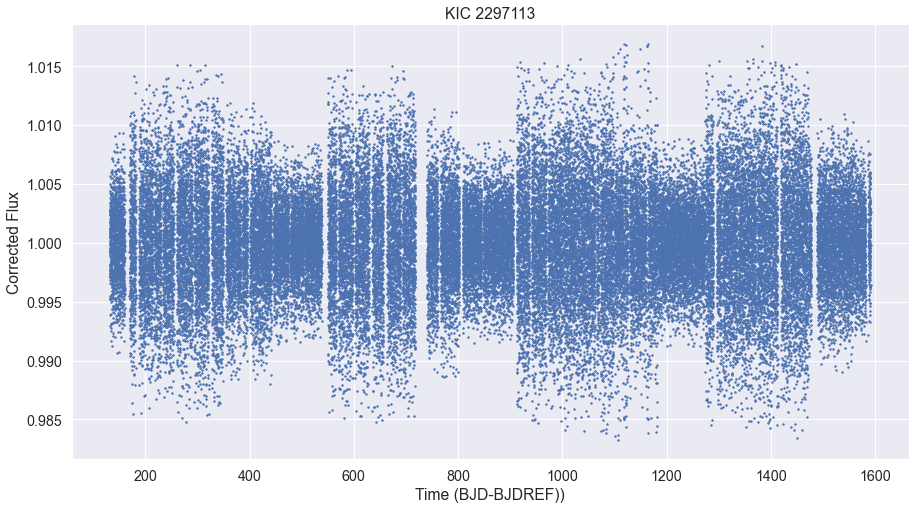

In [11]:
%matplotlib inline 

import seaborn as sns 
plt.figure(figsize=(15,8))
sns.set(font_scale=1.3) 
plt.scatter(binarytable['TIME'],1+binarytable['CORRECTED FLUX'],s=2)
plt.xlabel('Time (BJD-BJDREF))')
plt.ylabel('Corrected Flux')
plt.title(hdu.header['HLSPTARG'])
plt.show()

On a slightly negative note, only the normalized fluxes (which I think think are actually normalized magnitudes) are provided. We will also need to obtain the average magnitude for each of the sources, which we can do. 

We will return to reviewing individual files, let's next get some statistics regarding the entire sample

In [12]:
#we only needed to run this once to make the file. Just go ahead and import it from now on.
t = Table(names=('RA_OBJ','DEC_OBJ','KEPLERID','Quarter', 'EXPOSURE', 'CLUSTER','mmd_flux','mmd_mag'), \
              dtype=('f4','f4','i4','f4','f4', 'S8','f4','f4'))

for i in fitsfilesin:
    hdulist = fits.open(i)
    binarytable = Table(hdulist[1].data)
    mmd_flux=median_absolute_deviation(1+binarytable['CORRECTED FLUX'])
    #What if I add 1 to all the normalized flux values and then compute mags?
    mags=-2.5*np.log10(1+binarytable['CORRECTED FLUX'])
    mmd_mag=median_absolute_deviation(mags)
    t.add_row((hdulist[0].header['RA_OBJ'],hdulist[0].header['DEC_OBJ'],hdulist[0].header['KEPLERID'],hdulist[0].header['QUARTER'],hdulist[0].header['EXPOSURE'],hdulist[0].header['CLUSTER'],mmd_flux,mmd_mag))
    hdulist.close()
    
output='ColmanTable_NGC6791.txt'
t.write(output,format='ascii',overwrite=True)
t.show_in_browser(jsviewer=True)    

In [47]:
#t=pd.read_table('ColmanTable_NGC6791.txt',delimiter=' ')
t = Table.read('ColmanTable_NGC6791.txt', format='ascii')
t[0:3]

<Table length=3>
      RA_OBJ            DEC_OBJ      ...        mmd_mag       
     float64            float64      ...        float64       
------------------ ----------------- ... ---------------------
290.14349365234375 37.69501495361328 ... 0.0030812229961156845
 290.1452331542969  37.6962776184082 ...  0.004051644820719957
 290.1497497558594 37.69062423706055 ...  0.004013454541563988

I am going to help provide a sense of the location of this collection of light curves by plotting them atop the Kepler FOV. This code comes from Geert Barentsen.

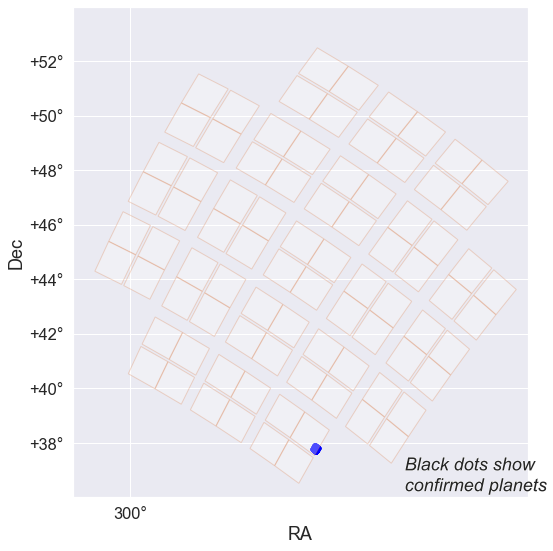

In [31]:
CAMPAIGN = 1000

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


p = plot.K2FootprintPlot(figsize=(8,8))
campaigns = np.arange(0, CAMPAIGN+1)
p.plot_campaign(CAMPAIGN, annotate_channels=False, facecolor='white',
                lw=1, edgecolor=colors[1], zorder=2,alpha=0.3)

text = plt.text(285.5, 36.8, 'Black dots show\nconfirmed planets', zorder=999, style='italic',
               fontsize=18, va='center', ha='left')

text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                       path_effects.Normal()])

plt.scatter(t['RA_OBJ'],t['DEC_OBJ'],color='blue',s=10)


plt.xlim([303, 279])
plt.ylim([36.01, 53.99])
plt.tight_layout()

Let's zoom way in to get a better look at the overlap...

Text(24.0, 0.5, 'DEC')

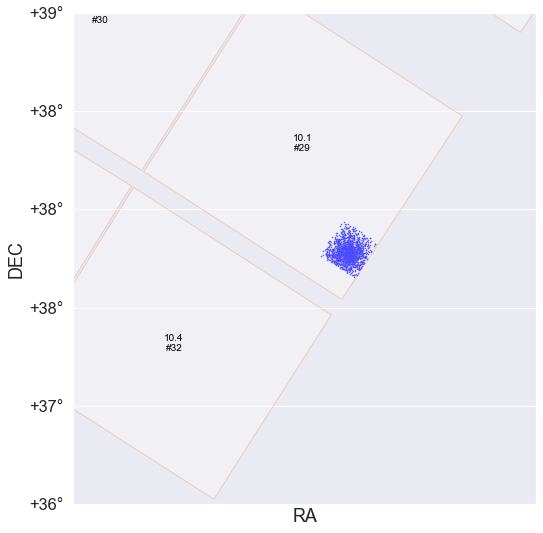

In [32]:
CAMPAIGN = 1000
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

p = plot.K2FootprintPlot(figsize=(8,8))
campaigns = np.arange(0, CAMPAIGN+1)
p.plot_campaign(CAMPAIGN, annotate_channels=True, facecolor='white',
                lw=1, edgecolor=colors[1], zorder=1,alpha=0.3)


text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                       path_effects.Normal()])

plt.scatter(t['RA_OBJ'],t['DEC_OBJ'],color='blue',s=0.25)


plt.xlim([292, 289])
plt.ylim([36.5, 39.0])
plt.xlabel('RA')
plt.ylabel('DEC')

I'm going to write the table generated to a text file in case we want to return to that information.

A preview of the table contents is shown below.

Next, we will examine some individual light curves.

In [33]:
df = t.to_pandas()
df[0:3]

RA_OBJ    DEC_OBJ  KEPLERID  Quarter   EXPOSURE   CLUSTER  mmd_flux  \
0  290.143494  37.695015   2297113     17.0  24.456804  NGC 6791  0.002837   
1  290.145233  37.696278   2297125     17.0  24.456804  NGC 6791  0.003733   
2  290.149750  37.690624   2297143     17.0  24.456804  NGC 6791  0.003697   

    mmd_mag  
0  0.003081  
1  0.004052  
2  0.004013

The source below was classified by Isobel as an EB

Text(0.5, 1.0, 'KIC 2570281')

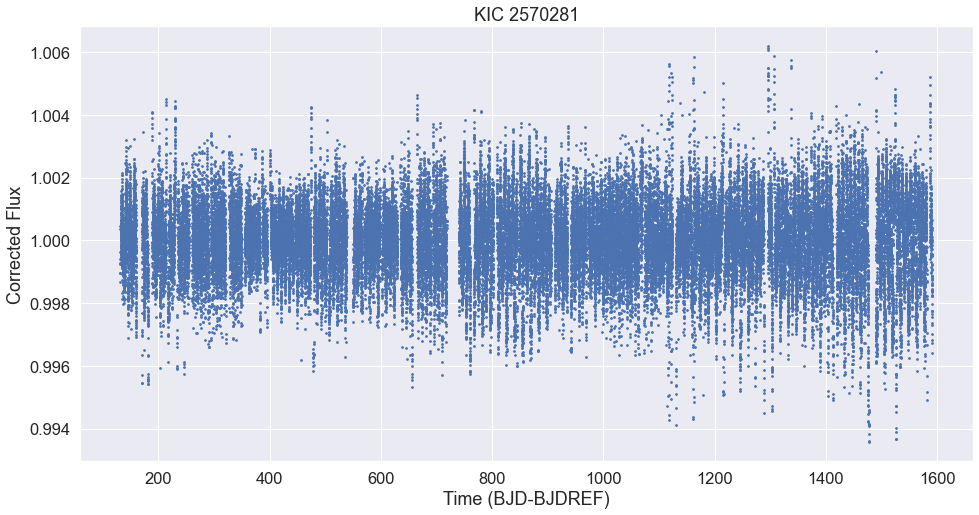

In [48]:
with fits.open(fitsfilesin[df.index[df['KEPLERID'] == 2570281].tolist()[0]]) as hdulist:
    binaryext = hdulist[1].data

binarytable = Table(binaryext)
binarytable[1:5]

plt.figure(figsize=(16,8))
sns.set(font_scale=1.5) 
plt.scatter(binarytable['TIME'],1+binarytable['CORRECTED FLUX'],s=3)
plt.xlabel('Time (BJD-BJDREF)')
plt.ylabel('Corrected Flux')
plt.title(hdulist[0].header['HLSPTARG'])

Doesn't that seem more like normalized mag than corrected flux? *Bob, what do you think?*

That's a pretty ratty light curve, so it's hard to tell what we are looking at here...we really need a periodogram to get more information. I am going to run a quick generalized Lomb-Scargle periodogram and Stellingwerf Phase-Dispersion Minimization periodogram (using Astrobase) on the LC above to see what periodicity and amplitude variability I get. I am making up a 1% error because errors have not been included in Colman's LCs. This takes a while to run, so be patient if you repeat this exercise.

In [25]:
times, mags, errs = binarytable['TIME'], binarytable['CORRECTED FLUX'],0.01*binarytable['CORRECTED FLUX']
glsp = periodbase.pgen_lsp(times,mags,errs)
bls=periodbase.bls_parallel_pfind(times,mags,errs)
spdm = periodbase.stellingwerf_pdm(times,mags,errs)

fileout='/Users/melinda/Dropbox/Research_NGC6791/PKL_files/'+str(hdulist[0].header['HLSPTARG'].rsplit()[1])+'.pkl'
print(fileout)

1516.3346519773913
1588.6720143770362


/Users/melinda/Dropbox/Research_NGC6791/PKL_files/2570281.pkl


In [26]:
cpf = checkplot.checkplot_pickle([glsp,spdm,bls],times, mags,errs,outfile=fileout,minbinelems=1, \
                                 objectinfo={'objectid': hdulist[0].header['HLSPTARG'],'ra': hdulist[0].header['RA_OBJ'],'decl': hdulist[0].header['DEC_OBJ'],'ndet': hdulist[0].header['TELAPSE']}) 

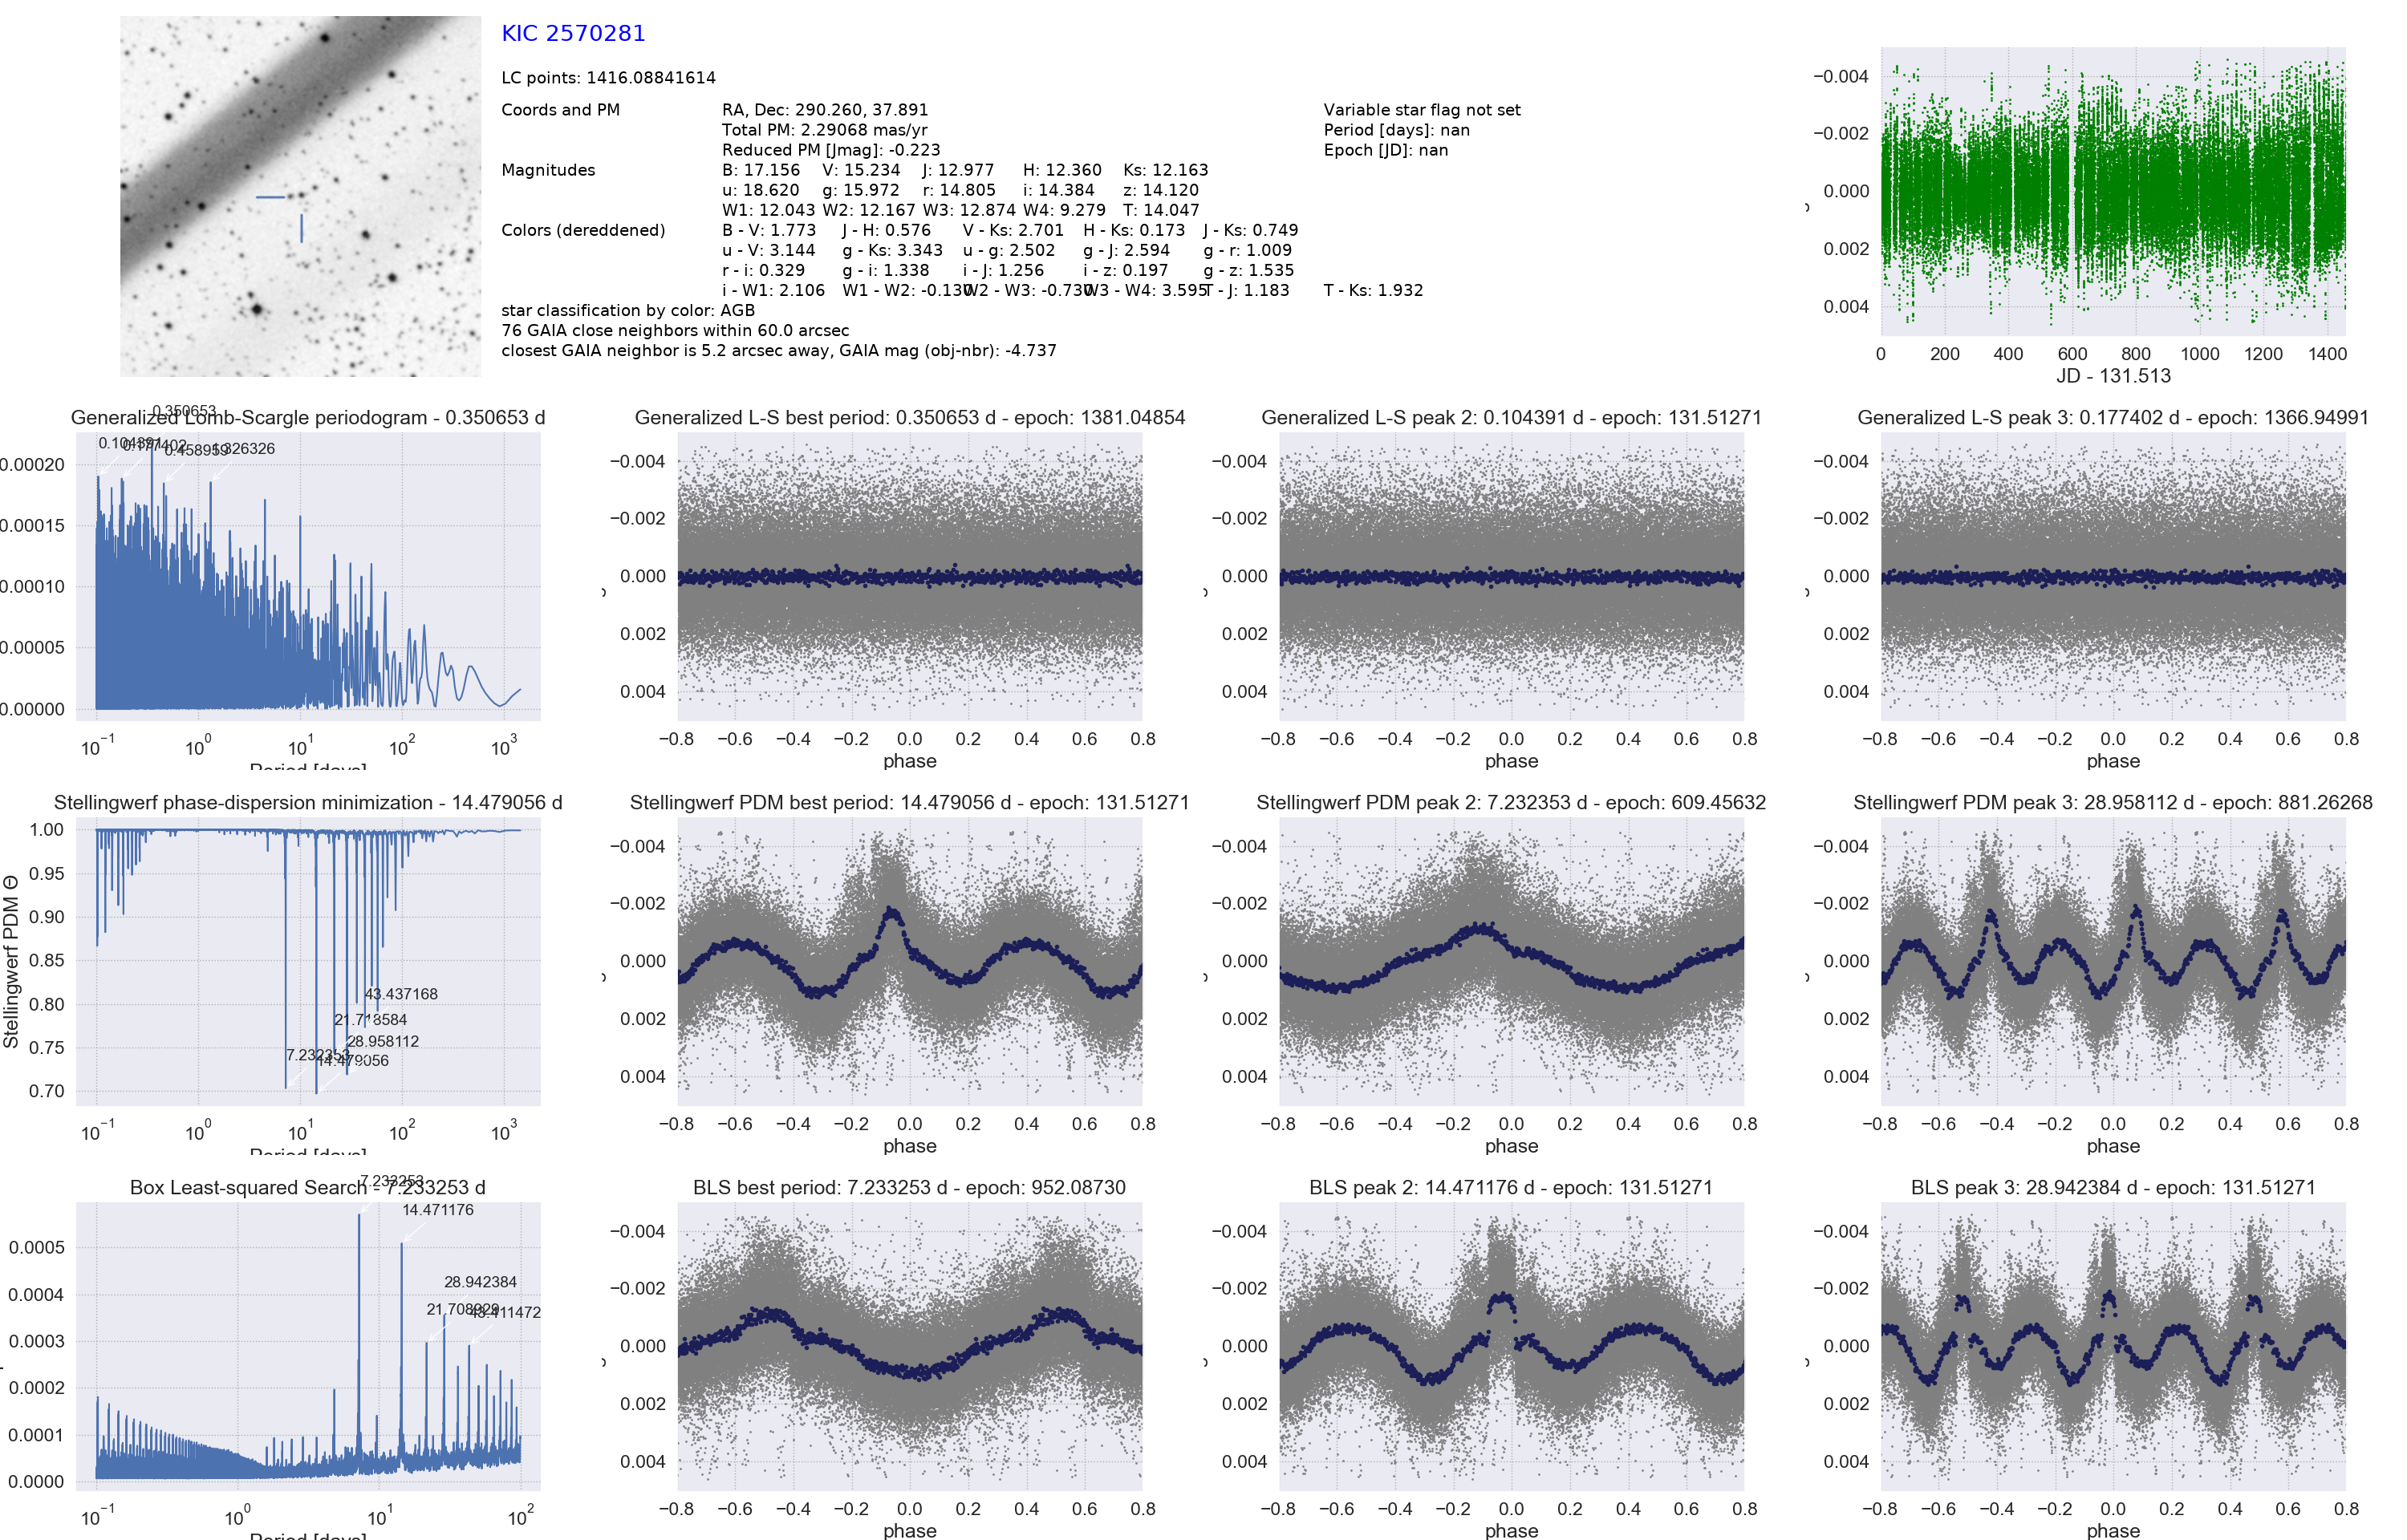

In [27]:
cpfpng = checkplot.checkplot_pickle_to_png(fileout, 'checkplot-pickle.png')
Image('checkplot-pickle.png')

Let's try this same exercise with the mags as fluxes, as Colman indicates in her header. Remember, I think she's reported normalized mag and not normalized flux. We can check this with a periodogram.

1516.3346519773913
1588.6720143770362


/Users/melinda/Dropbox/Research_NGC6791/PKL_files/2570281.pkl


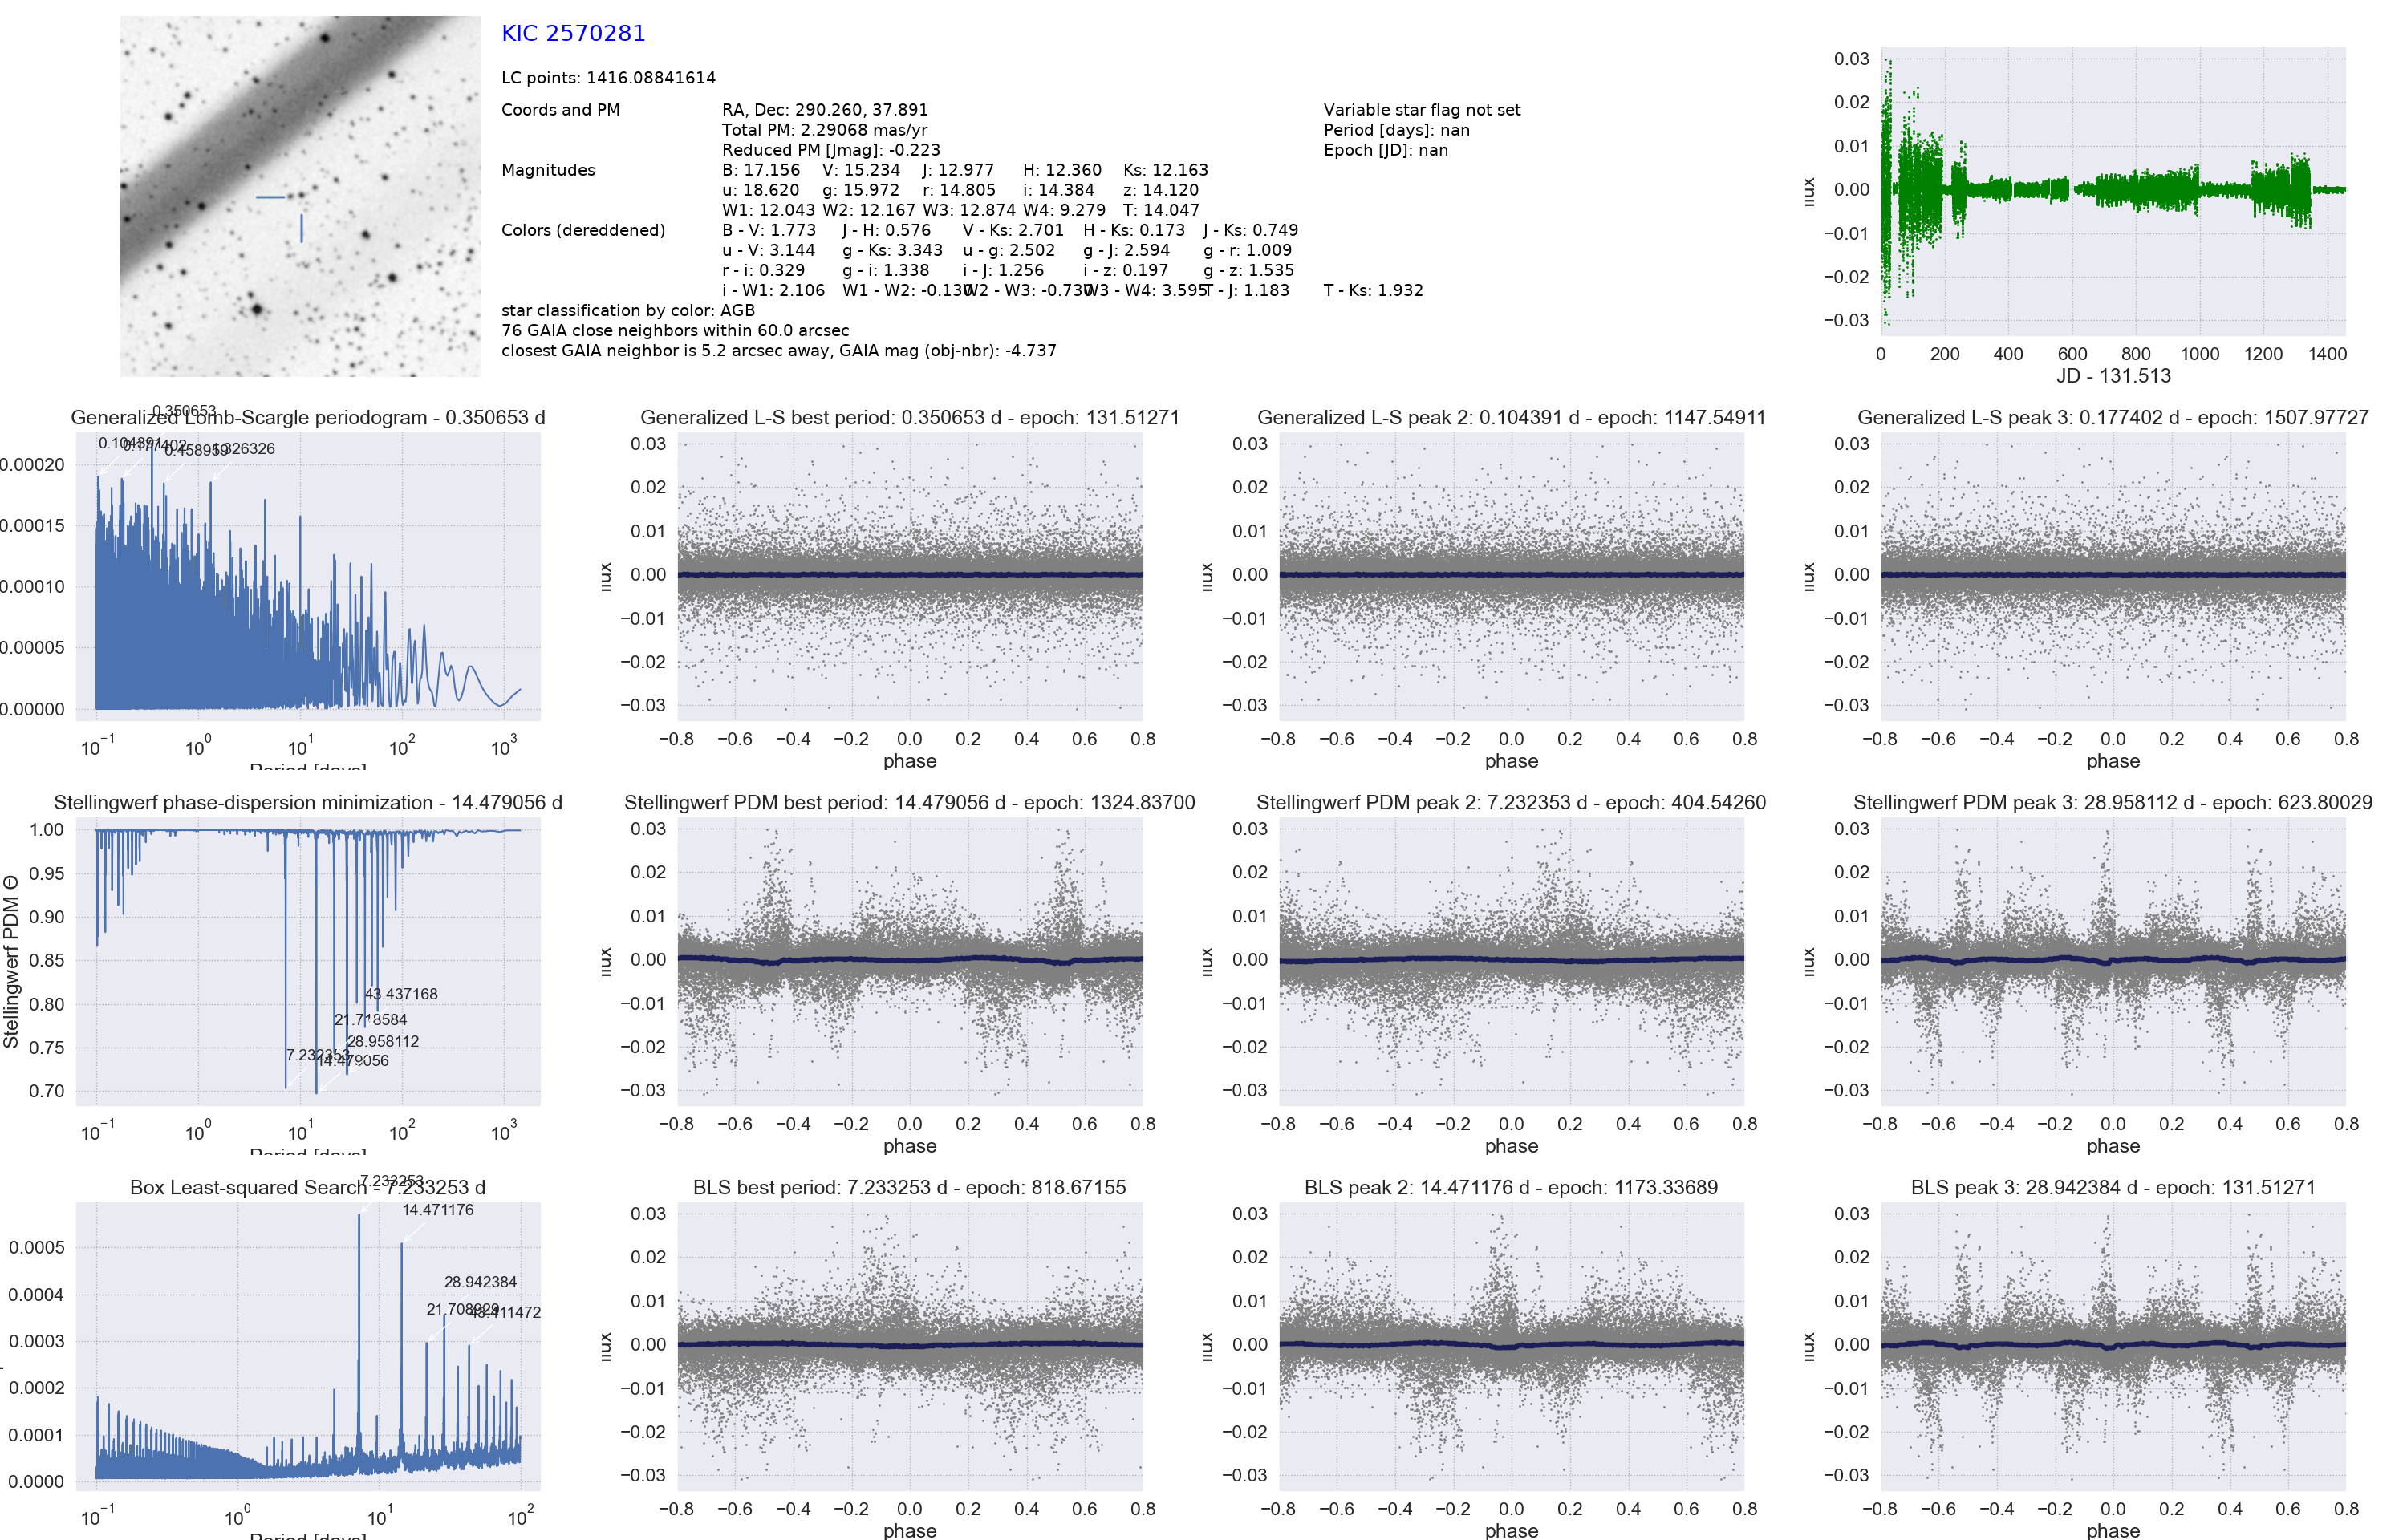

In [36]:
times, mags, errs = binarytable['TIME'], binarytable['CORRECTED FLUX'],0.01*binarytable['CORRECTED FLUX']
glsp = periodbase.pgen_lsp(times,mags,errs,magsarefluxes=True)
bls=periodbase.bls_parallel_pfind(times,mags,errs,magsarefluxes=True)
spdm = periodbase.stellingwerf_pdm(times,mags,errs,magsarefluxes=True)

fileout='/Users/melinda/Dropbox/Research_NGC6791/PKL_files/'+str(hdulist[0].header['HLSPTARG'].rsplit()[1])+'.pkl'
print(fileout)

cpf = checkplot.checkplot_pickle([glsp,spdm,bls],times, mags,errs,outfile=fileout,minbinelems=1,magsarefluxes=True, \
                                 objectinfo={'objectid': hdulist[0].header['HLSPTARG'],'ra': hdulist[0].header['RA_OBJ'],'decl': hdulist[0].header['DEC_OBJ'],'ndet': hdulist[0].header['TELAPSE']}) 
cpfpng = checkplot.checkplot_pickle_to_png(fileout, 'checkplot-pickle.png')
Image('checkplot-pickle.png')

Ok, that definitely doesn't look right...

What if we need to add 1 to her normalized flux values? Let's try that next and then recompute with magsarefluxes=True

In [39]:
times, mags, errs = binarytable['TIME'], 1+binarytable['CORRECTED FLUX'],0.01*binarytable['CORRECTED FLUX']
glsp = periodbase.pgen_lsp(times,mags,errs,magsarefluxes=True)
bls=periodbase.bls_parallel_pfind(times,mags,errs,magsarefluxes=True)
spdm = periodbase.stellingwerf_pdm(times,mags,errs,magsarefluxes=True)

1516.3346519773913
1588.6720143770362


/Users/melinda/Dropbox/Research_NGC6791/PKL_files/2570281.pkl


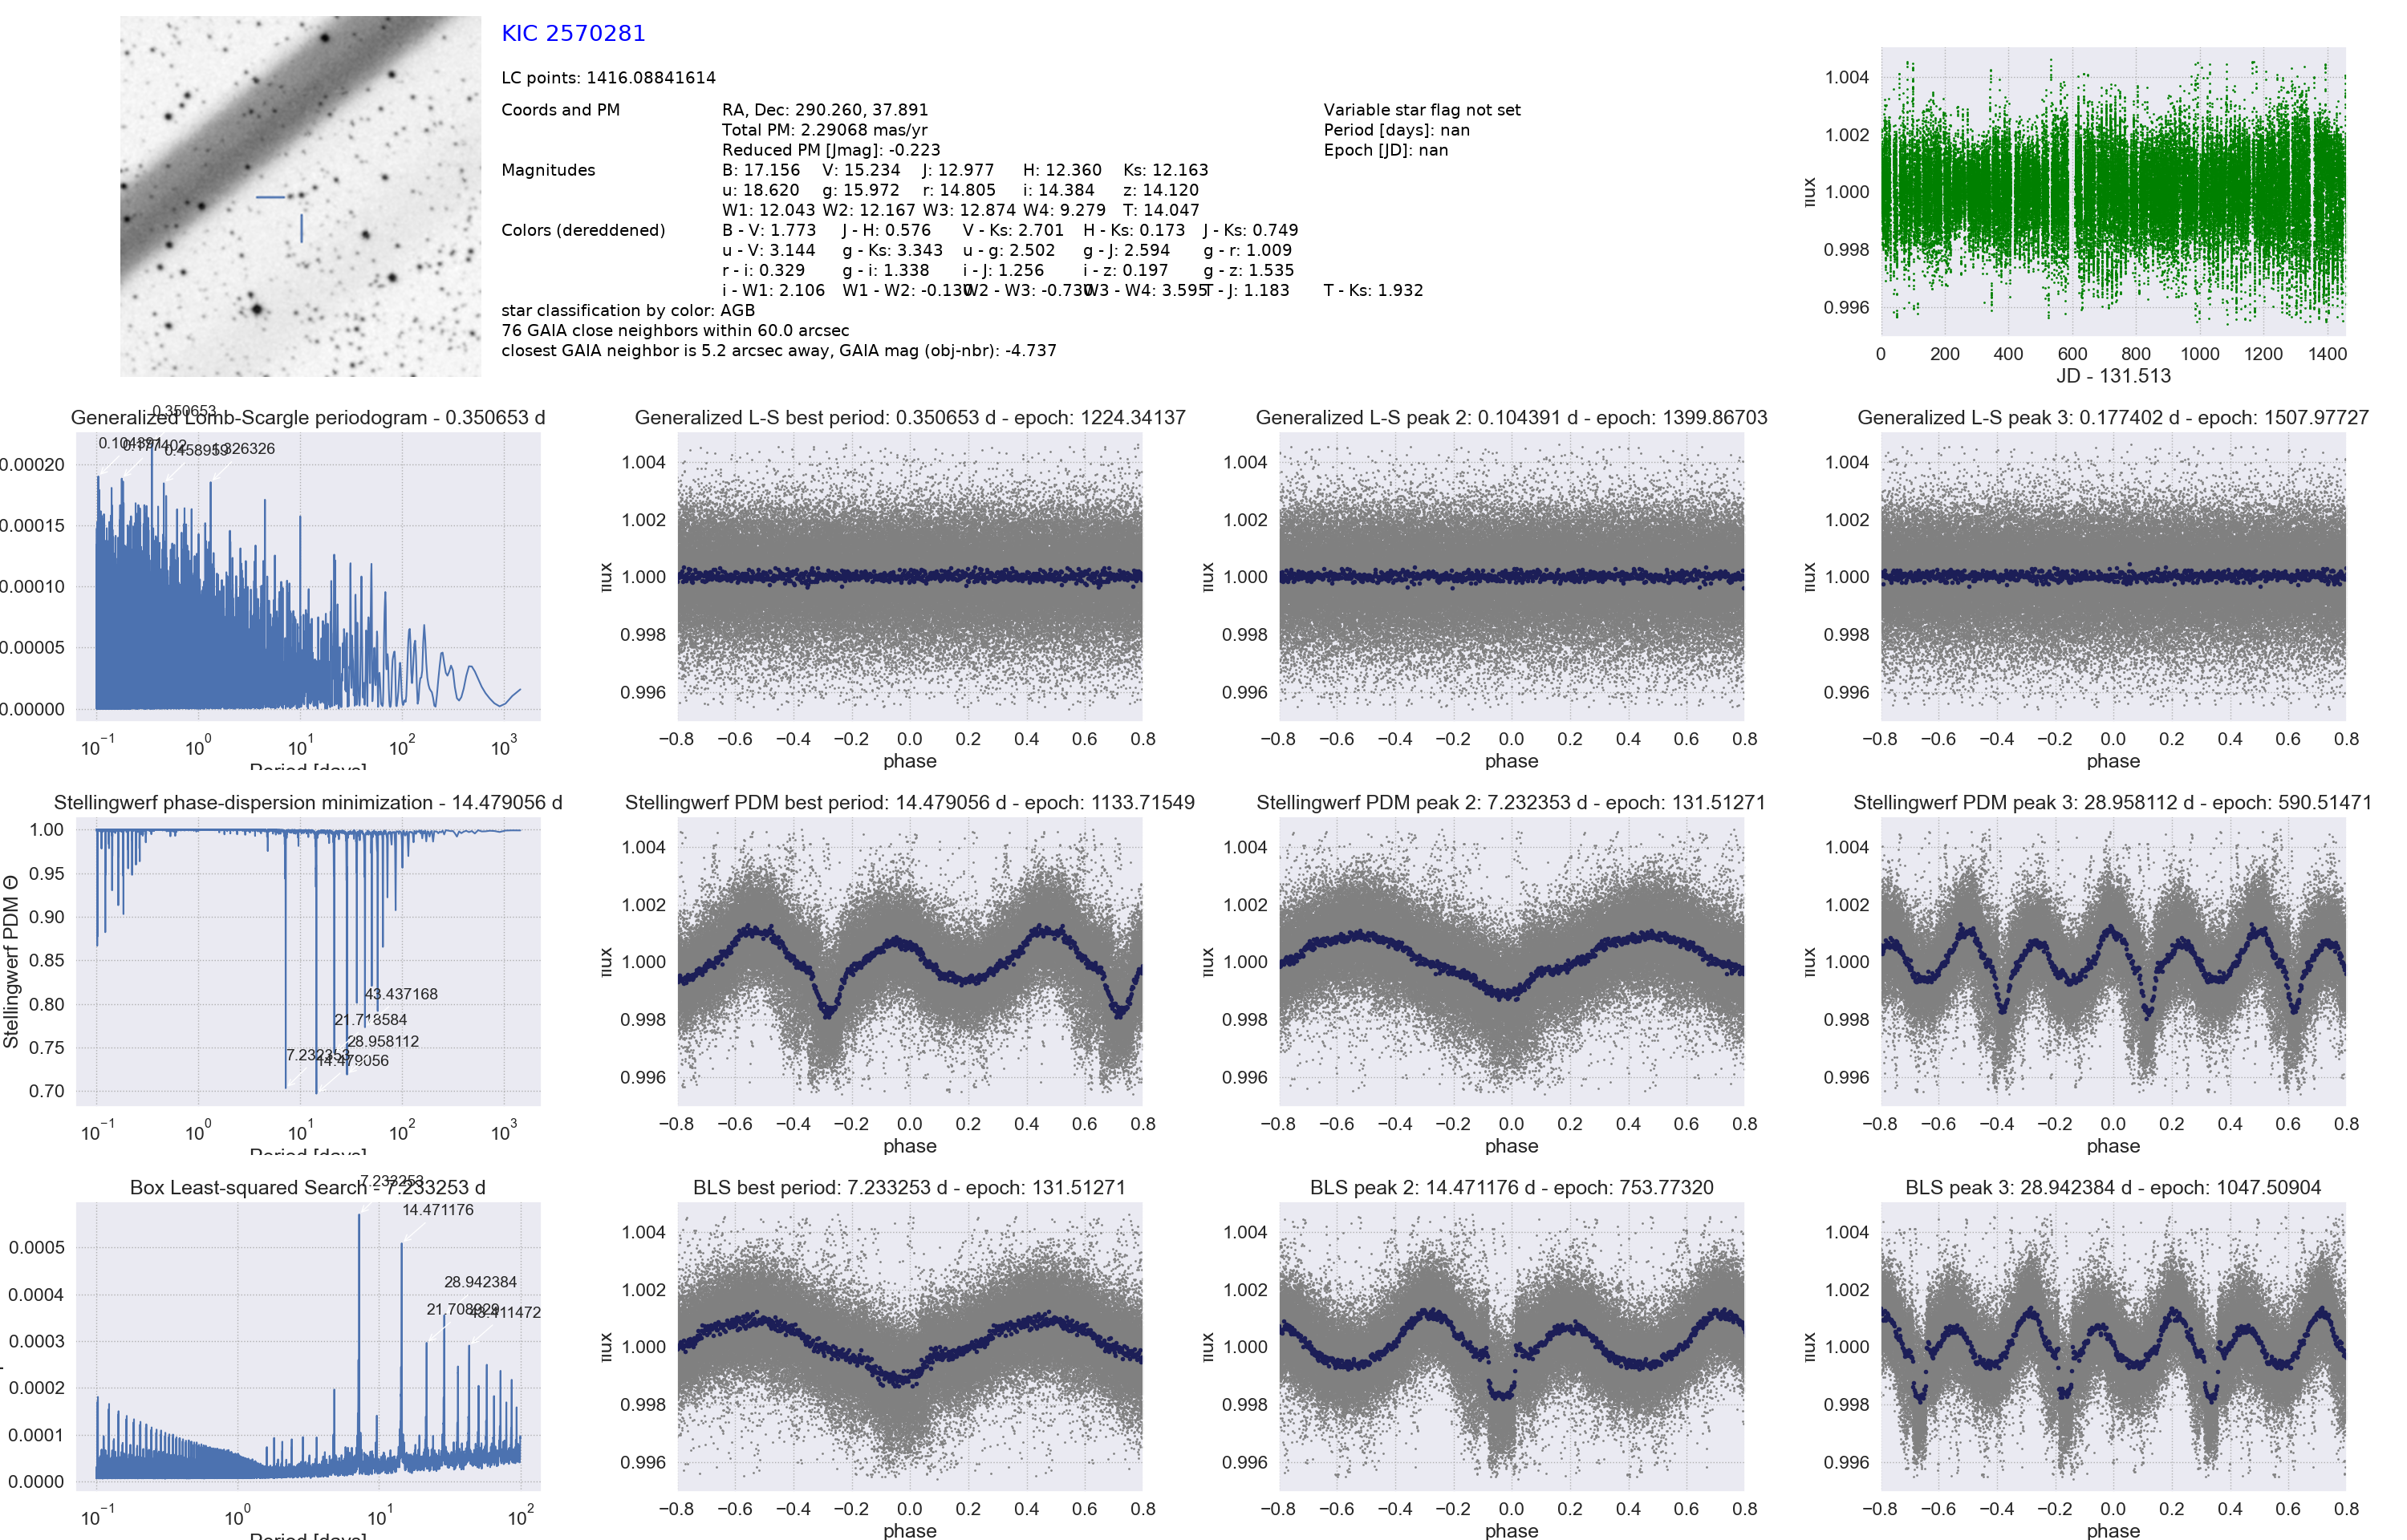

In [40]:
fileout='/Users/melinda/Dropbox/Research_NGC6791/PKL_files/'+str(hdulist[0].header['HLSPTARG'].rsplit()[1])+'.pkl'
print(fileout)

cpf = checkplot.checkplot_pickle([glsp,spdm,bls],times, mags,errs,outfile=fileout,minbinelems=1,magsarefluxes=True, \
                                 objectinfo={'objectid': hdulist[0].header['HLSPTARG'],'ra': hdulist[0].header['RA_OBJ'],'decl': hdulist[0].header['DEC_OBJ'],'ndet': hdulist[0].header['TELAPSE']}) 
cpfpng = checkplot.checkplot_pickle_to_png(fileout, 'checkplot-pickle.png')
Image('checkplot-pickle.png')

Ok, there we go. That's correct! I believe that these are, in fact, normalized fluxes that just need to be offset by adding one.

Bear in mind that the the Generalized Lomb-Scargle usually gets the period wrong for eclipsing binaries, which are less sinusoidal in LC shape. In the case of EBs, you'll want to run the Stellingwerf Phase-Dispersion Minimization (PDM) method instead. Similarly, to look for planets, you will run the the Box-Least-Squares fitting algorithm.

This is definitely the case with the eclipsing binary seen above, were the PDM light curves shown in the second row display the more characteristic elicpsing binary features. You'll see that each of the three periods are just harmonics of one another. This looks like an eclipsing binary with a period of 14.47 days. The power spectrum shows that the strongest power is associated with this period.

Let's try to find this source in the Gaia DR2 Catalog using the astroquery software platform. The radius parameter is provided in degrees, so make this value very small (~0.001 deg).

In [16]:
from astroquery.mast import Catalogs

In [17]:
with fits.open(fitsfilesin[4]) as hdulist:
    binaryext = hdulist[1].data

In [18]:
coords=str(hdulist[0].header['RA_OBJ'])+' '+str(hdulist[0].header['DEC_OBJ'])
print(coords)

290.1557051 37.69681174


In [34]:
catalog_data['source_id'][0]

'2051286516693495552'

In [38]:
catalog_data = Catalogs.query_region(coords, radius=0.0008,catalog="Gaia", version=2)
print("Number of results:",len(catalog_data))
catalog_data

Number of results: 1


<Table masked=True length=1>
    solution_id             designation          ...        distance      
       str19                   str28             ...        float64       
------------------- ---------------------------- ... ---------------------
1635721458409799680 Gaia DR2 2051286516693495552 ... 0.0006293146561116624

In [30]:
result[10]

<Table masked=True length=1>
   RA_ICRS     e_RA_ICRS    DE_ICRS     ...    e__FG_   __Gmag_      Var     
     deg          mas         deg       ...     e-/s      mag                
   float64      float32     float64     ...   float32   float32    bytes13   
-------------- --------- -------------- ... ----------- ------- -------------
290.1557041129     0.156  37.6968017945 ...       6.093  17.183 NOT_AVAILABLE

In [25]:
from astroquery.vizier import Vizier
v = Vizier()
from astropy import coordinates
from astropy import units as u
c = coordinates.SkyCoord(coords,unit=('deg','deg'),frame='icrs')
result = v.query_region(c, radius=0.0008*u.deg)
print(len(result))
result

31


TableList with 31 tables:
	'0:I/252/out' with 8 column(s) and 2 row(s) 
	'1:I/271/out' with 11 column(s) and 1 row(s) 
	'2:I/284/out' with 14 column(s) and 2 row(s) 
	'3:I/297/out' with 19 column(s) and 2 row(s) 
	'4:I/305/out' with 11 column(s) and 1 row(s) 
	'5:I/317/sample' with 13 column(s) and 2 row(s) 
	'6:I/319/xpm' with 25 column(s) and 1 row(s) 
	'7:I/324/igsl3' with 18 column(s) and 2 row(s) 
	'8:I/327/cmc15' with 9 column(s) and 1 row(s) 
	'9:I/329/urat1' with 16 column(s) and 1 row(s) 
	'10:I/337/gaia' with 14 column(s) and 1 row(s) 
	'11:I/339/hsoy' with 18 column(s) and 1 row(s) 
	'12:I/343/gps1' with 39 column(s) and 1 row(s) 
	'13:I/345/gaia2' with 32 column(s) and 1 row(s) 
	'14:I/347/gaia2dis' with 9 column(s) and 1 row(s) 
	'15:I/349/starhorse' with 19 column(s) and 1 row(s) 
	'16:II/246/out' with 15 column(s) and 1 row(s) 
	'17:II/294/sdss7' with 19 column(s) and 1 row(s) 
	'18:II/311/wise' with 22 column(s) and 1 row(s) 
	'19:II/328/allwise' with 28 column(s) and 1

for i in result:
    print (i.columns)

So we have many catalogs that seem to have information on this particular source. Gaia DR2, Kepler, and TESS are just three examples listed. Let's see the contents in one of them.

In [74]:
result[10]

<Table masked=True length=1>
   RA_ICRS     e_RA_ICRS    DE_ICRS     ...    e__FG_   __Gmag_      Var     
     deg          mas         deg       ...     e-/s      mag                
   float64      float32     float64     ...   float32   float32    bytes13   
-------------- --------- -------------- ... ----------- ------- -------------
290.1557041129     0.156  37.6968017945 ...       6.093  17.183 NOT_AVAILABLE

In [75]:
result[15]

<Table masked=True length=1>
   RA_ICRS        DE_ICRS            Source       ...    RGal       ruwe   
     deg            deg                           ...    kpc               
   float64        float64            int64        ...  float64    float64  
-------------- -------------- ------------------- ... ---------- ----------
290.1557039514  37.6968012909 2051286516693495552 ...   7.708366   0.921042

We see that the Gaia IDs match, which is a good sanity check. We have a ton of information on this source. It looks to be a 0.9 Rsun, 0.8 Msun dwarf star with strong proper motion. For reference, the MSTO mass of NGC 6791 is ~1.1 Msun and the bulk proper motion is -0.421,-2.269 mas/yr (both 2018 estimates). The error bars of the source location are also within the distance to NGC 6791. 

In [76]:
result[16]

<Table masked=True length=1>
 RAJ2000    DEJ2000        _2MASS        Jmag  ...  Bflg   Cflg   Xflg  Aflg
   deg        deg                        mag   ...                          
 float64    float64       bytes17      float32 ... bytes3 bytes3 uint8 uint8
---------- ---------- ---------------- ------- ... ------ ------ ----- -----
290.155735  37.696819 19203737+3741485  15.851 ...    111    000     0     0

We can see that the Kepler magnitude for this main sequence source is pretty faint (19th mag)

In [77]:
result[19]

<Table masked=True length=1>
      AllWISE         RAJ2000     DEJ2000     Im   ...  qph     d2M    _2M  
                        deg         deg            ...          arcs        
      bytes19         float64     float64   bytes2 ... bytes4 float32 bytes2
------------------- ----------- ----------- ------ ... ------ ------- ------
J192037.37+374147.9 290.1557488  37.6966528     Im ...   ABUU   0.600     2M

Another great match, as the V-mag and Kep-mag tend to be similar. This table is nice to plot a V vs V-K plot or a J vs. J-K plot.

Ideally we would want to add all this valuable information in a giant table for each source, so we'd have a code loop through these steps. Parameters I think we should include are as follows: Catalog IDs, Vmag, Jmag, Kmag, Teff, Rstar, Mstar, LClass, parallax/distance, proper motion, and all associated errors --- metallicities would be great too if we could find them. 

I think this is a good start! *Thoughts?* We can also add information from UCAC4 (I have this stored as photref.cat). I can also provide information regarding the HAT identifier if you think that's helpful.

I think we could do this by using the Pandas dataframe format. I find it more flexible when I need to add and drop columns/rows. We would simply append the parameters of interest. Let's start off by making those parametrs emptpy dataframe columns. 

In [318]:
#We can start by compiling information from other catalogs (Gaia + TESS + Kepler + SDSS) into one super catalog to rule them all. First, I'll run it on just two sources to make sure it works with the iterations.

df = t.to_pandas()
df=df.drop(columns=['Quarter', 'EXPOSURE','CLUSTER'])
df=df.rename(columns={"RA_OBJ": "RA", "DEC_OBJ": "DEC", "KEPLERID":"KEPID"})

df=df.assign(GaiaID=0,KIC=0,TIC=0,Vmag=0,Jmag=0,Kmag=0,kepmag=0,Imag=0,Rmag=0,Bmag=0,pmRA=0,pmDE=0,e_pmRA=0,e_pmDE=0,Rad=0,Mass=0,Lum=0,logg=0,LClass=0,\
         RV=0,Teff=0,Dist=0,e_Dist=0,ProbCluster=0)
a1=0
a2=345# len(df)

import time
start_time = time.time()
for i in range(a1,a2):#len(df)):
    coords=str(df.RA[i])+' '+str(df.DEC[i])
    c = coordinates.SkyCoord(coords,unit=('deg','deg'),frame='icrs')
    result = v.query_region(c, radius=0.0005*u.deg)
    print(len(result),'total catalogs for source',i)
    #collect all the values and choose the one with the best precision
    Vmags, Jmags, Kmags, Imags, Rmags, Bmags,Rads,Masses,Lums,loggs,RVs,Teffs,\
    =[],[],[],[],[],[],[],[],[],[],[],[]
    for ii in result:
        if ('GAIA' in ii.columns):
            if ('-' not in str(ii['GAIA'][0])):
                df.GaiaID[i]=ii['GAIA'][0]
        if ('KIC' in ii.columns):
            if ('-' not in str(ii['KIC'][0])):
                df.KIC[i]=ii['KIC'][0]
        if (df.TIC[i]==0) & ('TIC' in (ii.columns)):
            df.TIC[i]=ii['TIC'][0]
        if (df.LClass[i]==0) & ('LClass' in (ii.columns)):
            df.LClass[i]=str(ii['LClass'][0])
        if ('Vmag' in (ii.columns)):
            Vmags.append(ii['Vmag'][0])
        if ('Jmag' in (ii.columns)):
            Jmags.append(ii['Jmag'][0])
        if ('jmag' in (ii.columns)):
            Jmags.append(ii['jmag'][0])
        if ('Kmag' in (ii.columns)):
            Kmags.append(ii['Kmag'][0])
        if ('kmag' in (ii.columns)):
            Kmags.append(ii['kmag'][0])
        if ('kepmag' in (ii.columns)):
            df.kepmag[i]=str(ii['kepmag'][0])
        if ('Imag' in (ii.columns)):
            Imags.append(ii['Imag'][0])
        if ('Rmag' in (ii.columns)):
            Rmags.append(ii['Rmag'][0])
        if ('Bmag' in (ii.columns)):
            Bmags.append(ii['Bmag'][0])
        if ('RV' in (ii.columns)):
            if (type(ii['RV'][0])==float):
                RVs.append(ii['RV'][0])
        #get proper motions + distance + reddening + cluster probability from Gaia only
        if ('pmRA' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.pmRA[i]=str(ii['pmRA'][0])
        if ('pmDE' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.pmDE[i]=str(ii['pmDE'][0])
        if ('e_pmRA' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.e_pmRA[i]=str(ii['e_pmRA'][0])
        if ('e_pmDE' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.e_pmDE[i]=str(ii['e_pmDE'][0])
        if ('Dist' in (ii.columns)) & ('GAIA' in (ii.columns)):
            if ('-' not in str(ii['Dist'][0])):
                df.Dist[i]=ii['Dist'][0]
        if ('e_Dist' in (ii.columns)) & ('GAIA' in (ii.columns)):
            if ('-' not in str(ii['e_Dist'][0])):
                df.e_Dist[i]=ii['e_Dist'][0]
        if ('Proba' in (ii.columns)):
            df.ProbCluster[i]=ii['Proba'][0]        
        ###
        if ('Rad' in (ii.columns)):
            Rads.append(ii['Rad'][0])
        if ('Mass' in (ii.columns)):
            Masses.append(ii['Mass'][0])
        if ('Lum' in (ii.columns)):
            if (type(ii['Lum'][0])==float):
                Lums.append(ii['Lum'][0])
        if ('logg' in (ii.columns)):
            loggs.append(ii['logg'][0])
        if ('Teff' in (ii.columns)):
            Teffs.append(ii['Teff'][0])
    df.Vmag[i]=str(round(np.nanmedian(Vmags),2))
    df.Jmag[i]=str(round(np.nanmedian(Jmags),2))
    df.Kmag[i]=str(round(np.nanmedian(Kmags),2))
    df.Kmag[i]=str(round(np.nanmedian(Kmags),2))
    df.Imag[i]=str(round(np.nanmedian(Imags),2))
    df.Rmag[i]=str(round(np.nanmedian(Rmags),2))
    df.Bmag[i]=str(round(np.nanmedian(Bmags),2))
    df.Rad[i]=str(round(np.nanmedian(Rads),2))
    df.Mass[i]=str(round(np.nanmedian(Masses),2))
    df.Lum[i]=str(round(np.nanmedian(Lums),2))
    df.logg[i]=str(round(np.nanmedian(loggs),2))
    df.RV[i]=str(round(np.nanmedian(RVs),2))
    df.Teff[i]=str(round(np.nanmedian(Teffs),2))
    print(round((time.time() - start_time),1),'seconds | ',round((time.time() - start_time)/60.0,1),'minutes | ',\
         ound((time.time() - start_time)/3600.0,1),'hours')
    print('____________________________________')

perfile=round((time.time() - start_time)/(a2-a1),2)
print("This executes in %s seconds for a given LC source" % perfile)
print("We can expect that this will take",round(len(df)*perfile/3600,2),"hours to run on the entire catalog.")

df[a1:a2]
t2 = Table.from_pandas(df)
t2.show_in_browser(jsviewer=True)    

33 total catalogs for source 0
43.8 seconds |  0.7 minutes
____________________________________
23 total catalogs for source 1
82.0 seconds |  1.4 minutes
____________________________________
31 total catalogs for source 2
122.1 seconds |  2.0 minutes
____________________________________
32 total catalogs for source 3
163.8 seconds |  2.7 minutes
____________________________________
31 total catalogs for source 4
204.0 seconds |  3.4 minutes
____________________________________
23 total catalogs for source 5
243.7 seconds |  4.1 minutes
____________________________________
30 total catalogs for source 6
274.5 seconds |  4.6 minutes
____________________________________
25 total catalogs for source 7
309.2 seconds |  5.2 minutes
____________________________________
31 total catalogs for source 8
344.3 seconds |  5.7 minutes
____________________________________
31 total catalogs for source 9
377.4 seconds |  6.3 minutes
____________________________________
31 total catalogs for source 10


31 total catalogs for source 83
3365.8 seconds |  56.1 minutes
____________________________________
35 total catalogs for source 84
3409.1 seconds |  56.8 minutes
____________________________________
31 total catalogs for source 85
3450.5 seconds |  57.5 minutes
____________________________________
32 total catalogs for source 86
3495.3 seconds |  58.3 minutes
____________________________________
33 total catalogs for source 87
3545.2 seconds |  59.1 minutes
____________________________________
30 total catalogs for source 88
3591.2 seconds |  59.9 minutes
____________________________________
31 total catalogs for source 89
3627.6 seconds |  60.5 minutes
____________________________________
28 total catalogs for source 90
3666.9 seconds |  61.1 minutes
____________________________________
23 total catalogs for source 91
3712.6 seconds |  61.9 minutes
____________________________________
35 total catalogs for source 92
3755.0 seconds |  62.6 minutes
____________________________________


6692.9 seconds |  111.5 minutes
____________________________________
34 total catalogs for source 165
6734.6 seconds |  112.2 minutes
____________________________________
53 total catalogs for source 166
6774.0 seconds |  112.9 minutes
____________________________________
21 total catalogs for source 167
6810.5 seconds |  113.5 minutes
____________________________________
28 total catalogs for source 168
6850.4 seconds |  114.2 minutes
____________________________________
23 total catalogs for source 169
6889.5 seconds |  114.8 minutes
____________________________________
32 total catalogs for source 170
6927.9 seconds |  115.5 minutes
____________________________________
31 total catalogs for source 171
6964.4 seconds |  116.1 minutes
____________________________________
29 total catalogs for source 172
7001.8 seconds |  116.7 minutes
____________________________________
33 total catalogs for source 173
7041.0 seconds |  117.4 minutes
____________________________________
25 total cata

32 total catalogs for source 245
9725.6 seconds |  162.1 minutes
____________________________________
35 total catalogs for source 246
9762.2 seconds |  162.7 minutes
____________________________________
41 total catalogs for source 247
9798.1 seconds |  163.3 minutes
____________________________________
26 total catalogs for source 248
9837.7 seconds |  164.0 minutes
____________________________________
31 total catalogs for source 249
9873.5 seconds |  164.6 minutes
____________________________________
32 total catalogs for source 250
9910.8 seconds |  165.2 minutes
____________________________________
21 total catalogs for source 251
9948.4 seconds |  165.8 minutes
____________________________________
30 total catalogs for source 252
9987.5 seconds |  166.5 minutes
____________________________________
24 total catalogs for source 253
10023.6 seconds |  167.1 minutes
____________________________________
23 total catalogs for source 254
10063.4 seconds |  167.7 minutes
_______________

31 total catalogs for source 325
12801.5 seconds |  213.4 minutes
____________________________________
30 total catalogs for source 326
12836.6 seconds |  213.9 minutes
____________________________________
30 total catalogs for source 327
12874.1 seconds |  214.6 minutes
____________________________________
31 total catalogs for source 328
12910.1 seconds |  215.2 minutes
____________________________________
28 total catalogs for source 329
12949.3 seconds |  215.8 minutes
____________________________________
32 total catalogs for source 330
12988.0 seconds |  216.5 minutes
____________________________________
54 total catalogs for source 331
13028.5 seconds |  217.1 minutes
____________________________________
30 total catalogs for source 332
13064.4 seconds |  217.7 minutes
____________________________________
31 total catalogs for source 333
13099.1 seconds |  218.3 minutes
____________________________________
33 total catalogs for source 334
13133.8 seconds |  218.9 minutes
_______

In [327]:
a1=345
a2=a1+345# len(df)

import time
start_time = time.time()
for i in range(a1,a2):#len(df)):
    coords=str(df.RA[i])+' '+str(df.DEC[i])
    c = coordinates.SkyCoord(coords,unit=('deg','deg'),frame='icrs')
    result = v.query_region(c, radius=0.0005*u.deg)
    print(len(result),'total catalogs for source',i)
    #collect all the values and choose the one with the best precision
    Vmags, Jmags, Kmags, Imags, Rmags, Bmags,Rads,Masses,Lums,loggs,RVs,Teffs,\
    =[],[],[],[],[],[],[],[],[],[],[],[]
    for ii in result:
        if ('GAIA' in ii.columns):
            if ('-' not in str(ii['GAIA'][0])):
                df.GaiaID[i]=ii['GAIA'][0]
        if ('KIC' in ii.columns):
            if ('-' not in str(ii['KIC'][0])):
                df.KIC[i]=ii['KIC'][0]
        if (df.TIC[i]==0) & ('TIC' in (ii.columns)):
            df.TIC[i]=ii['TIC'][0]
        if (df.LClass[i]==0) & ('LClass' in (ii.columns)):
            df.LClass[i]=str(ii['LClass'][0])
        if ('Vmag' in (ii.columns)):
            Vmags.append(ii['Vmag'][0])
        if ('Jmag' in (ii.columns)):
            Jmags.append(ii['Jmag'][0])
        if ('jmag' in (ii.columns)):
            Jmags.append(ii['jmag'][0])
        if ('Kmag' in (ii.columns)):
            Kmags.append(ii['Kmag'][0])
        if ('kmag' in (ii.columns)):
            Kmags.append(ii['kmag'][0])
        if ('kepmag' in (ii.columns)):
            df.kepmag[i]=str(ii['kepmag'][0])
        if ('Imag' in (ii.columns)):
            Imags.append(ii['Imag'][0])
        if ('Rmag' in (ii.columns)):
            Rmags.append(ii['Rmag'][0])
        if ('Bmag' in (ii.columns)):
            Bmags.append(ii['Bmag'][0])
        if ('RV' in (ii.columns)):
            if (type(ii['RV'][0])==float):
                RVs.append(ii['RV'][0])
        #get proper motions + distance + reddening + cluster probability from Gaia only
        if ('pmRA' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.pmRA[i]=str(ii['pmRA'][0])
        if ('pmDE' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.pmDE[i]=str(ii['pmDE'][0])
        if ('e_pmRA' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.e_pmRA[i]=str(ii['e_pmRA'][0])
        if ('e_pmDE' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.e_pmDE[i]=str(ii['e_pmDE'][0])
        if ('Dist' in (ii.columns)) & ('GAIA' in (ii.columns)):
            if ('-' not in str(ii['Dist'][0])):
                df.Dist[i]=ii['Dist'][0]
        if ('e_Dist' in (ii.columns)) & ('GAIA' in (ii.columns)):
            if ('-' not in str(ii['e_Dist'][0])):
                df.e_Dist[i]=ii['e_Dist'][0]
        if ('Proba' in (ii.columns)):
            df.ProbCluster[i]=ii['Proba'][0]        
        ###
        if ('Rad' in (ii.columns)):
            Rads.append(ii['Rad'][0])
        if ('Mass' in (ii.columns)):
            Masses.append(ii['Mass'][0])
        if ('Lum' in (ii.columns)):
            if (type(ii['Lum'][0])==float):
                Lums.append(ii['Lum'][0])
        if ('logg' in (ii.columns)):
            loggs.append(ii['logg'][0])
        if ('Teff' in (ii.columns)):
            Teffs.append(ii['Teff'][0])
    df.Vmag[i]=str(round(np.nanmedian(Vmags),2))
    df.Jmag[i]=str(round(np.nanmedian(Jmags),2))
    df.Kmag[i]=str(round(np.nanmedian(Kmags),2))
    df.Kmag[i]=str(round(np.nanmedian(Kmags),2))
    df.Imag[i]=str(round(np.nanmedian(Imags),2))
    df.Rmag[i]=str(round(np.nanmedian(Rmags),2))
    df.Bmag[i]=str(round(np.nanmedian(Bmags),2))
    df.Rad[i]=str(round(np.nanmedian(Rads),2))
    df.Mass[i]=str(round(np.nanmedian(Masses),2))
    df.Lum[i]=str(round(np.nanmedian(Lums),2))
    df.logg[i]=str(round(np.nanmedian(loggs),2))
    df.RV[i]=str(round(np.nanmedian(RVs),2))
    df.Teff[i]=str(round(np.nanmedian(Teffs),2))
    print(round((time.time() - start_time),1),'seconds | ',round((time.time() - start_time)/60.0,2),'minutes | ',\
         round((time.time() - start_time)/3600.0,4),'hours')
    print('____________________________________')

perfile=round((time.time() - start_time)/(a2-a1),2)
print("This executes in %s seconds for a given LC source" % perfile)
print("We can expect that this will take",round(len(df)*perfile/3600,2),"hours to run on the entire catalog.")

df[a1:a2]
t2 = Table.from_pandas(df)
t2.show_in_browser(jsviewer=True)    

29 total catalogs for source 345
2.9 seconds |  0.05 minutes |  0.0008 hours
____________________________________
18 total catalogs for source 346
5.8 seconds |  0.1 minutes |  0.0016 hours
____________________________________
31 total catalogs for source 347
8.9 seconds |  0.15 minutes |  0.0025 hours
____________________________________
33 total catalogs for source 348
12.0 seconds |  0.2 minutes |  0.0033 hours
____________________________________
30 total catalogs for source 349
15.1 seconds |  0.25 minutes |  0.0042 hours
____________________________________
31 total catalogs for source 350
18.1 seconds |  0.3 minutes |  0.005 hours
____________________________________
43 total catalogs for source 351
22.4 seconds |  0.37 minutes |  0.0062 hours
____________________________________
34 total catalogs for source 352
25.5 seconds |  0.42 minutes |  0.0071 hours
____________________________________
65 total catalogs for source 353
30.6 seconds |  0.51 minutes |  0.0085 hours
_________

2174.8 seconds |  36.25 minutes |  0.6041 hours
____________________________________
25 total catalogs for source 416
2210.9 seconds |  36.85 minutes |  0.6141 hours
____________________________________
30 total catalogs for source 417
2250.6 seconds |  37.51 minutes |  0.6252 hours
____________________________________
38 total catalogs for source 418
2287.6 seconds |  38.13 minutes |  0.6354 hours
____________________________________
56 total catalogs for source 419
2326.9 seconds |  38.78 minutes |  0.6463 hours
____________________________________
32 total catalogs for source 420
2362.3 seconds |  39.37 minutes |  0.6562 hours
____________________________________
31 total catalogs for source 421
2397.1 seconds |  39.95 minutes |  0.6659 hours
____________________________________
30 total catalogs for source 422
2431.8 seconds |  40.53 minutes |  0.6755 hours
____________________________________
28 total catalogs for source 423
2470.3 seconds |  41.17 minutes |  0.6862 hours
________

30 total catalogs for source 485
4857.9 seconds |  80.96 minutes |  1.3494 hours
____________________________________
26 total catalogs for source 486
4894.3 seconds |  81.57 minutes |  1.3595 hours
____________________________________
28 total catalogs for source 487
4929.6 seconds |  82.16 minutes |  1.3693 hours
____________________________________
23 total catalogs for source 488
4966.4 seconds |  82.77 minutes |  1.3796 hours
____________________________________
41 total catalogs for source 489
5004.4 seconds |  83.41 minutes |  1.3901 hours
____________________________________
28 total catalogs for source 490
5042.0 seconds |  84.03 minutes |  1.4006 hours
____________________________________
32 total catalogs for source 491
5080.0 seconds |  84.67 minutes |  1.4111 hours
____________________________________
43 total catalogs for source 492
5120.6 seconds |  85.34 minutes |  1.4224 hours
____________________________________
32 total catalogs for source 493
5157.5 seconds |  85.96

7537.5 seconds |  125.63 minutes |  2.0938 hours
____________________________________
35 total catalogs for source 555
7579.4 seconds |  126.32 minutes |  2.1054 hours
____________________________________
32 total catalogs for source 556
7617.0 seconds |  126.95 minutes |  2.1158 hours
____________________________________
30 total catalogs for source 557
7659.3 seconds |  127.66 minutes |  2.1276 hours
____________________________________
44 total catalogs for source 558
7699.9 seconds |  128.33 minutes |  2.1389 hours
____________________________________
36 total catalogs for source 559
7740.1 seconds |  129.0 minutes |  2.15 hours
____________________________________
27 total catalogs for source 560
7779.9 seconds |  129.67 minutes |  2.1611 hours
____________________________________
29 total catalogs for source 561
7816.6 seconds |  130.28 minutes |  2.1713 hours
____________________________________
26 total catalogs for source 562
7851.3 seconds |  130.85 minutes |  2.1809 hours
__

10191.2 seconds |  169.85 minutes |  2.8309 hours
____________________________________
30 total catalogs for source 624
10230.1 seconds |  170.5 minutes |  2.8417 hours
____________________________________
80 total catalogs for source 625
10273.3 seconds |  171.22 minutes |  2.8537 hours
____________________________________
70 total catalogs for source 626
10317.5 seconds |  171.96 minutes |  2.866 hours
____________________________________
25 total catalogs for source 627
10357.2 seconds |  172.62 minutes |  2.877 hours
____________________________________
43 total catalogs for source 628
10395.7 seconds |  173.26 minutes |  2.8877 hours
____________________________________
30 total catalogs for source 629
10434.9 seconds |  173.92 minutes |  2.8986 hours
____________________________________
26 total catalogs for source 630
10474.5 seconds |  174.58 minutes |  2.9096 hours
____________________________________
77 total catalogs for source 631
10519.2 seconds |  175.32 minutes |  2.922 

In [328]:
a1=a2
a2=a1+345# len(df)

import time
start_time = time.time()
for i in range(a1,a2):#len(df)):
    coords=str(df.RA[i])+' '+str(df.DEC[i])
    c = coordinates.SkyCoord(coords,unit=('deg','deg'),frame='icrs')
    result = v.query_region(c, radius=0.0005*u.deg)
    print(len(result),'total catalogs for source',i)
    #collect all the values and choose the one with the best precision
    Vmags, Jmags, Kmags, Imags, Rmags, Bmags,Rads,Masses,Lums,loggs,RVs,Teffs,\
    =[],[],[],[],[],[],[],[],[],[],[],[]
    for ii in result:
        if ('GAIA' in ii.columns):
            if ('-' not in str(ii['GAIA'][0])):
                df.GaiaID[i]=ii['GAIA'][0]
        if ('KIC' in ii.columns):
            if ('-' not in str(ii['KIC'][0])):
                df.KIC[i]=ii['KIC'][0]
        if (df.TIC[i]==0) & ('TIC' in (ii.columns)):
            df.TIC[i]=ii['TIC'][0]
        if (df.LClass[i]==0) & ('LClass' in (ii.columns)):
            df.LClass[i]=str(ii['LClass'][0])
        if ('Vmag' in (ii.columns)):
            Vmags.append(ii['Vmag'][0])
        if ('Jmag' in (ii.columns)):
            Jmags.append(ii['Jmag'][0])
        if ('jmag' in (ii.columns)):
            Jmags.append(ii['jmag'][0])
        if ('Kmag' in (ii.columns)):
            Kmags.append(ii['Kmag'][0])
        if ('kmag' in (ii.columns)):
            Kmags.append(ii['kmag'][0])
        if ('kepmag' in (ii.columns)):
            df.kepmag[i]=str(ii['kepmag'][0])
        if ('Imag' in (ii.columns)):
            Imags.append(ii['Imag'][0])
        if ('Rmag' in (ii.columns)):
            Rmags.append(ii['Rmag'][0])
        if ('Bmag' in (ii.columns)):
            Bmags.append(ii['Bmag'][0])
        if ('RV' in (ii.columns)):
            if (type(ii['RV'][0])==float):
                RVs.append(ii['RV'][0])
        #get proper motions + distance + reddening + cluster probability from Gaia only
        if ('pmRA' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.pmRA[i]=str(ii['pmRA'][0])
        if ('pmDE' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.pmDE[i]=str(ii['pmDE'][0])
        if ('e_pmRA' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.e_pmRA[i]=str(ii['e_pmRA'][0])
        if ('e_pmDE' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.e_pmDE[i]=str(ii['e_pmDE'][0])
        if ('Dist' in (ii.columns)) & ('GAIA' in (ii.columns)):
            if ('-' not in str(ii['Dist'][0])):
                df.Dist[i]=ii['Dist'][0]
        if ('e_Dist' in (ii.columns)) & ('GAIA' in (ii.columns)):
            if ('-' not in str(ii['e_Dist'][0])):
                df.e_Dist[i]=ii['e_Dist'][0]
        if ('Proba' in (ii.columns)):
            df.ProbCluster[i]=ii['Proba'][0]        
        ###
        if ('Rad' in (ii.columns)):
            Rads.append(ii['Rad'][0])
        if ('Mass' in (ii.columns)):
            Masses.append(ii['Mass'][0])
        if ('Lum' in (ii.columns)):
            if (type(ii['Lum'][0])==float):
                Lums.append(ii['Lum'][0])
        if ('logg' in (ii.columns)):
            loggs.append(ii['logg'][0])
        if ('Teff' in (ii.columns)):
            Teffs.append(ii['Teff'][0])
    df.Vmag[i]=str(round(np.nanmedian(Vmags),2))
    df.Jmag[i]=str(round(np.nanmedian(Jmags),2))
    df.Kmag[i]=str(round(np.nanmedian(Kmags),2))
    df.Kmag[i]=str(round(np.nanmedian(Kmags),2))
    df.Imag[i]=str(round(np.nanmedian(Imags),2))
    df.Rmag[i]=str(round(np.nanmedian(Rmags),2))
    df.Bmag[i]=str(round(np.nanmedian(Bmags),2))
    df.Rad[i]=str(round(np.nanmedian(Rads),2))
    df.Mass[i]=str(round(np.nanmedian(Masses),2))
    df.Lum[i]=str(round(np.nanmedian(Lums),2))
    df.logg[i]=str(round(np.nanmedian(loggs),2))
    df.RV[i]=str(round(np.nanmedian(RVs),2))
    df.Teff[i]=str(round(np.nanmedian(Teffs),2))
    print(round((time.time() - start_time),1),'seconds | ',round((time.time() - start_time)/60.0,1),'minutes')
    print('____________________________________')

perfile=round((time.time() - start_time)/(a2-a1),2)
print("This executes in %s seconds for a given LC source" % perfile)
print("We can expect that this will take",round(len(df)*perfile/3600,2),"hours to run on the entire catalog.")

df[a1:a2]
t2 = Table.from_pandas(df)
t2.show_in_browser(jsviewer=True)    

61 total catalogs for source 690
39.0 seconds |  0.6 minutes
____________________________________
33 total catalogs for source 691
77.1 seconds |  1.3 minutes
____________________________________
23 total catalogs for source 692
119.0 seconds |  2.0 minutes
____________________________________
34 total catalogs for source 693
161.4 seconds |  2.7 minutes
____________________________________
31 total catalogs for source 694
207.3 seconds |  3.5 minutes
____________________________________
22 total catalogs for source 695
251.7 seconds |  4.2 minutes
____________________________________
29 total catalogs for source 696
296.1 seconds |  4.9 minutes
____________________________________
24 total catalogs for source 697
337.4 seconds |  5.6 minutes
____________________________________
47 total catalogs for source 698
378.1 seconds |  6.3 minutes
____________________________________
25 total catalogs for source 699
415.8 seconds |  6.9 minutes
____________________________________
32 total cat

29 total catalogs for source 772
3186.7 seconds |  53.1 minutes
____________________________________
24 total catalogs for source 773
3225.7 seconds |  53.8 minutes
____________________________________
33 total catalogs for source 774
3261.4 seconds |  54.4 minutes
____________________________________
30 total catalogs for source 775
3297.7 seconds |  55.0 minutes
____________________________________
31 total catalogs for source 776
3337.7 seconds |  55.6 minutes
____________________________________
30 total catalogs for source 777
3374.5 seconds |  56.2 minutes
____________________________________
30 total catalogs for source 778
3413.0 seconds |  56.9 minutes
____________________________________
39 total catalogs for source 779
3451.7 seconds |  57.5 minutes
____________________________________
40 total catalogs for source 780
3489.5 seconds |  58.2 minutes
____________________________________
30 total catalogs for source 781
3526.5 seconds |  58.8 minutes
___________________________

6351.2 seconds |  105.9 minutes
____________________________________
26 total catalogs for source 854
6390.5 seconds |  106.5 minutes
____________________________________
29 total catalogs for source 855
6430.0 seconds |  107.2 minutes
____________________________________
29 total catalogs for source 856
6468.7 seconds |  107.8 minutes
____________________________________
33 total catalogs for source 857
6507.2 seconds |  108.5 minutes
____________________________________
34 total catalogs for source 858
6546.5 seconds |  109.1 minutes
____________________________________
37 total catalogs for source 859
6584.3 seconds |  109.7 minutes
____________________________________
25 total catalogs for source 860
6621.6 seconds |  110.4 minutes
____________________________________
31 total catalogs for source 861
6660.9 seconds |  111.0 minutes
____________________________________
23 total catalogs for source 862
6698.6 seconds |  111.6 minutes
____________________________________
29 total cata

30 total catalogs for source 934
9604.9 seconds |  160.1 minutes
____________________________________
34 total catalogs for source 935
9641.7 seconds |  160.7 minutes
____________________________________
30 total catalogs for source 936
9682.9 seconds |  161.4 minutes
____________________________________
67 total catalogs for source 937
9727.0 seconds |  162.1 minutes
____________________________________
26 total catalogs for source 938
9767.0 seconds |  162.8 minutes
____________________________________
18 total catalogs for source 939
9805.0 seconds |  163.4 minutes
____________________________________
20 total catalogs for source 940
9844.0 seconds |  164.1 minutes
____________________________________
33 total catalogs for source 941
9887.3 seconds |  164.8 minutes
____________________________________
33 total catalogs for source 942
9933.2 seconds |  165.6 minutes
____________________________________
33 total catalogs for source 943
9975.7 seconds |  166.3 minutes
_________________

32 total catalogs for source 1014
12860.8 seconds |  214.3 minutes
____________________________________
30 total catalogs for source 1015
12897.7 seconds |  215.0 minutes
____________________________________
29 total catalogs for source 1016
12941.9 seconds |  215.7 minutes
____________________________________
17 total catalogs for source 1017
12982.3 seconds |  216.4 minutes
____________________________________
25 total catalogs for source 1018
13019.2 seconds |  217.0 minutes
____________________________________
34 total catalogs for source 1019
13060.8 seconds |  217.7 minutes
____________________________________
88 total catalogs for source 1020
13107.4 seconds |  218.5 minutes
____________________________________
32 total catalogs for source 1021
13149.9 seconds |  219.2 minutes
____________________________________
26 total catalogs for source 1022
13191.0 seconds |  219.9 minutes
____________________________________
37 total catalogs for source 1023
13230.5 seconds |  220.5 minut

In [329]:
a1=a2
a2=len(df)

import time
start_time = time.time()
for i in range(a1,a2):#len(df)):
    coords=str(df.RA[i])+' '+str(df.DEC[i])
    c = coordinates.SkyCoord(coords,unit=('deg','deg'),frame='icrs')
    result = v.query_region(c, radius=0.0005*u.deg)
    print(len(result),'total catalogs for source',i)
    #collect all the values and choose the one with the best precision
    Vmags, Jmags, Kmags, Imags, Rmags, Bmags,Rads,Masses,Lums,loggs,RVs,Teffs,\
    =[],[],[],[],[],[],[],[],[],[],[],[]
    for ii in result:
        if ('GAIA' in ii.columns):
            if ('-' not in str(ii['GAIA'][0])):
                df.GaiaID[i]=ii['GAIA'][0]
        if ('KIC' in ii.columns):
            if ('-' not in str(ii['KIC'][0])):
                df.KIC[i]=ii['KIC'][0]
        if (df.TIC[i]==0) & ('TIC' in (ii.columns)):
            df.TIC[i]=ii['TIC'][0]
        if (df.LClass[i]==0) & ('LClass' in (ii.columns)):
            df.LClass[i]=str(ii['LClass'][0])
        if ('Vmag' in (ii.columns)):
            Vmags.append(ii['Vmag'][0])
        if ('Jmag' in (ii.columns)):
            Jmags.append(ii['Jmag'][0])
        if ('jmag' in (ii.columns)):
            Jmags.append(ii['jmag'][0])
        if ('Kmag' in (ii.columns)):
            Kmags.append(ii['Kmag'][0])
        if ('kmag' in (ii.columns)):
            Kmags.append(ii['kmag'][0])
        if ('kepmag' in (ii.columns)):
            df.kepmag[i]=str(ii['kepmag'][0])
        if ('Imag' in (ii.columns)):
            Imags.append(ii['Imag'][0])
        if ('Rmag' in (ii.columns)):
            Rmags.append(ii['Rmag'][0])
        if ('Bmag' in (ii.columns)):
            Bmags.append(ii['Bmag'][0])
        if ('RV' in (ii.columns)):
            if (type(ii['RV'][0])==float):
                RVs.append(ii['RV'][0])
        #get proper motions + distance + reddening + cluster probability from Gaia only
        if ('pmRA' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.pmRA[i]=str(ii['pmRA'][0])
        if ('pmDE' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.pmDE[i]=str(ii['pmDE'][0])
        if ('e_pmRA' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.e_pmRA[i]=str(ii['e_pmRA'][0])
        if ('e_pmDE' in (ii.columns)) & ('GAIA' in (ii.columns)):
            df.e_pmDE[i]=str(ii['e_pmDE'][0])
        if ('Dist' in (ii.columns)) & ('GAIA' in (ii.columns)):
            if ('-' not in str(ii['Dist'][0])):
                df.Dist[i]=ii['Dist'][0]
        if ('e_Dist' in (ii.columns)) & ('GAIA' in (ii.columns)):
            if ('-' not in str(ii['e_Dist'][0])):
                df.e_Dist[i]=ii['e_Dist'][0]
        if ('Proba' in (ii.columns)):
            df.ProbCluster[i]=ii['Proba'][0]        
        ###
        if ('Rad' in (ii.columns)):
            Rads.append(ii['Rad'][0])
        if ('Mass' in (ii.columns)):
            Masses.append(ii['Mass'][0])
        if ('Lum' in (ii.columns)):
            if (type(ii['Lum'][0])==float):
                Lums.append(ii['Lum'][0])
        if ('logg' in (ii.columns)):
            loggs.append(ii['logg'][0])
        if ('Teff' in (ii.columns)):
            Teffs.append(ii['Teff'][0])
    df.Vmag[i]=str(round(np.nanmedian(Vmags),2))
    df.Jmag[i]=str(round(np.nanmedian(Jmags),2))
    df.Kmag[i]=str(round(np.nanmedian(Kmags),2))
    df.Kmag[i]=str(round(np.nanmedian(Kmags),2))
    df.Imag[i]=str(round(np.nanmedian(Imags),2))
    df.Rmag[i]=str(round(np.nanmedian(Rmags),2))
    df.Bmag[i]=str(round(np.nanmedian(Bmags),2))
    df.Rad[i]=str(round(np.nanmedian(Rads),2))
    df.Mass[i]=str(round(np.nanmedian(Masses),2))
    df.Lum[i]=str(round(np.nanmedian(Lums),2))
    df.logg[i]=str(round(np.nanmedian(loggs),2))
    df.RV[i]=str(round(np.nanmedian(RVs),2))
    df.Teff[i]=str(round(np.nanmedian(Teffs),2))
    print(round((time.time() - start_time),1),'seconds | ',round((time.time() - start_time)/60.0,1),'minutes')
    print('____________________________________')

perfile=round((time.time() - start_time)/(a2-a1),2)
print("This executes in %s seconds for a given LC source" % perfile)
print("We can expect that this will take",round(len(df)*perfile/3600,2),"hours to run on the entire catalog.")

df[a1:a2]
t2 = Table.from_pandas(df)
t2.show_in_browser(jsviewer=True)    

32 total catalogs for source 1035
46.0 seconds |  0.8 minutes
____________________________________
28 total catalogs for source 1036
88.9 seconds |  1.5 minutes
____________________________________
31 total catalogs for source 1037
129.5 seconds |  2.2 minutes
____________________________________
31 total catalogs for source 1038
164.5 seconds |  2.7 minutes
____________________________________
32 total catalogs for source 1039
201.4 seconds |  3.4 minutes
____________________________________
23 total catalogs for source 1040
235.7 seconds |  3.9 minutes
____________________________________
34 total catalogs for source 1041
272.0 seconds |  4.5 minutes
____________________________________
26 total catalogs for source 1042
309.9 seconds |  5.2 minutes
____________________________________
31 total catalogs for source 1043
348.6 seconds |  5.8 minutes
____________________________________
31 total catalogs for source 1044
386.2 seconds |  6.4 minutes
____________________________________
26

29 total catalogs for source 1116
3239.3 seconds |  54.0 minutes
____________________________________
23 total catalogs for source 1117
3275.1 seconds |  54.6 minutes
____________________________________
32 total catalogs for source 1118
3315.0 seconds |  55.3 minutes
____________________________________
27 total catalogs for source 1119
3353.7 seconds |  55.9 minutes
____________________________________
23 total catalogs for source 1120
3395.7 seconds |  56.6 minutes
____________________________________
28 total catalogs for source 1121
3431.9 seconds |  57.2 minutes
____________________________________
29 total catalogs for source 1122
3469.5 seconds |  57.8 minutes
____________________________________
22 total catalogs for source 1123
3505.8 seconds |  58.4 minutes
____________________________________
33 total catalogs for source 1124
3544.0 seconds |  59.1 minutes
____________________________________
25 total catalogs for source 1125
3586.4 seconds |  59.8 minutes
_________________

6305.2 seconds |  105.1 minutes
____________________________________
16 total catalogs for source 1197
6340.4 seconds |  105.7 minutes
____________________________________
33 total catalogs for source 1198
6377.1 seconds |  106.3 minutes
____________________________________
32 total catalogs for source 1199
6411.1 seconds |  106.9 minutes
____________________________________
25 total catalogs for source 1200
6446.8 seconds |  107.4 minutes
____________________________________
45 total catalogs for source 1201
6484.3 seconds |  108.1 minutes
____________________________________
23 total catalogs for source 1202
6519.0 seconds |  108.6 minutes
____________________________________
62 total catalogs for source 1203
6559.0 seconds |  109.3 minutes
____________________________________
28 total catalogs for source 1204
6595.3 seconds |  109.9 minutes
____________________________________
25 total catalogs for source 1205
6629.9 seconds |  110.5 minutes
____________________________________
32 t

29 total catalogs for source 1276
9325.4 seconds |  155.4 minutes
____________________________________
26 total catalogs for source 1277
9365.3 seconds |  156.1 minutes
____________________________________
31 total catalogs for source 1278
9401.6 seconds |  156.7 minutes
____________________________________
29 total catalogs for source 1279
9445.1 seconds |  157.4 minutes
____________________________________
34 total catalogs for source 1280
9486.8 seconds |  158.1 minutes
____________________________________
30 total catalogs for source 1281
9527.9 seconds |  158.8 minutes
____________________________________
36 total catalogs for source 1282
9563.4 seconds |  159.4 minutes
____________________________________
60 total catalogs for source 1283
9608.6 seconds |  160.1 minutes
____________________________________
35 total catalogs for source 1284
9648.0 seconds |  160.8 minutes
____________________________________
31 total catalogs for source 1285
9685.2 seconds |  161.4 minutes
_______

32 total catalogs for source 1355
12226.1 seconds |  203.8 minutes
____________________________________
35 total catalogs for source 1356
12262.6 seconds |  204.4 minutes
____________________________________
25 total catalogs for source 1357
12295.8 seconds |  204.9 minutes
____________________________________
22 total catalogs for source 1358
12328.5 seconds |  205.5 minutes
____________________________________
29 total catalogs for source 1359
12365.5 seconds |  206.1 minutes
____________________________________
32 total catalogs for source 1360
12402.4 seconds |  206.7 minutes
____________________________________
23 total catalogs for source 1361
12436.0 seconds |  207.3 minutes
____________________________________
26 total catalogs for source 1362
12474.5 seconds |  207.9 minutes
____________________________________
31 total catalogs for source 1363
12513.6 seconds |  208.6 minutes
____________________________________
52 total catalogs for source 1364
12557.0 seconds |  209.3 minut

Ok, so now I know that this method works. We can indeed create a super catalog of information pertaining to these LCs right from this Jupyter notebook. As estimated above, it will take close to six hours to run this algorithm on the entire sample (in a notebook, anway). We should do this over the weekend and then we can input the datafile to create some plots. I'm excited to see some census information regarding this population of objects.

Below I'll create a few preliminary figures with this smaller data sample. These will include a Vmag vs. mmd plot, a few plot to explore the dataset correlations, and a V versus V-K plot with mmd values overplotted atop. With more luminosity and temperature data, I can also make a CMD with MESA tracks overplotted.

We need to ensure we are working with floats, first.

In [330]:
df['Vmag'] = df['Vmag'].astype(float)
df['Kmag'] = df['Kmag'].astype(float)
df['VminK']=df['Vmag']-df['Kmag']
df['Jmag'] = df['Jmag'].astype(float)
df['JminK']=df['Jmag']-df['Kmag']
df['Mass'] = df['Mass'].astype(float)
df['Rad'] = df['Rad'].astype(float)
df['Lum'] = df['Lum'].astype(float)
df['Teff'] = df['Teff'].astype(float)
df['Vmag'] = df['Vmag'].astype(float)
df['Jmag'] = df['Jmag'].astype(float)
df['VminK'] = df['VminK'].astype(float)
df['logg'] = df['logg'].astype(float)
df['RV'] = df['RV'].astype(float)
df['JminK'] = df['JminK'].astype(float)

In [412]:
t2 = Table.from_pandas(df)
output='ColmanTable_NGC6791_FullTable.dat'
t2.write(output,format='ascii',overwrite=True)


(-0.01, 0.05)

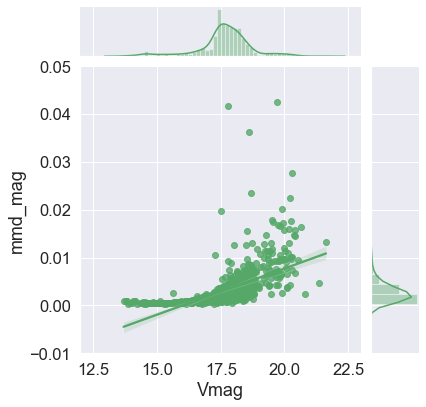

In [340]:
import scipy.stats as stats

sns.jointplot(data=df[df.Vmag>1], x=df.Vmag[df.Vmag>1], y=df.mmd_mag[df.Vmag>1], kind='reg', color='g')#.annotate(stats.pearsonr)
plt.xlim(12,23)
plt.ylim(-0.01,0.05)

There seems to be a moderate correlation in our subsample of higher mmd among fainter stars. This could be because the data are intrinsically noisier and not because the amplitude variations are stronger. It would be interesting to see if the correlation holds when we determine the amplitude variability. To do so, we would need to run periodograms, fit a Fourier Transform to the resultant light curves, and measure the variability amplitude.

<Figure size 720x720 with 0 Axes>

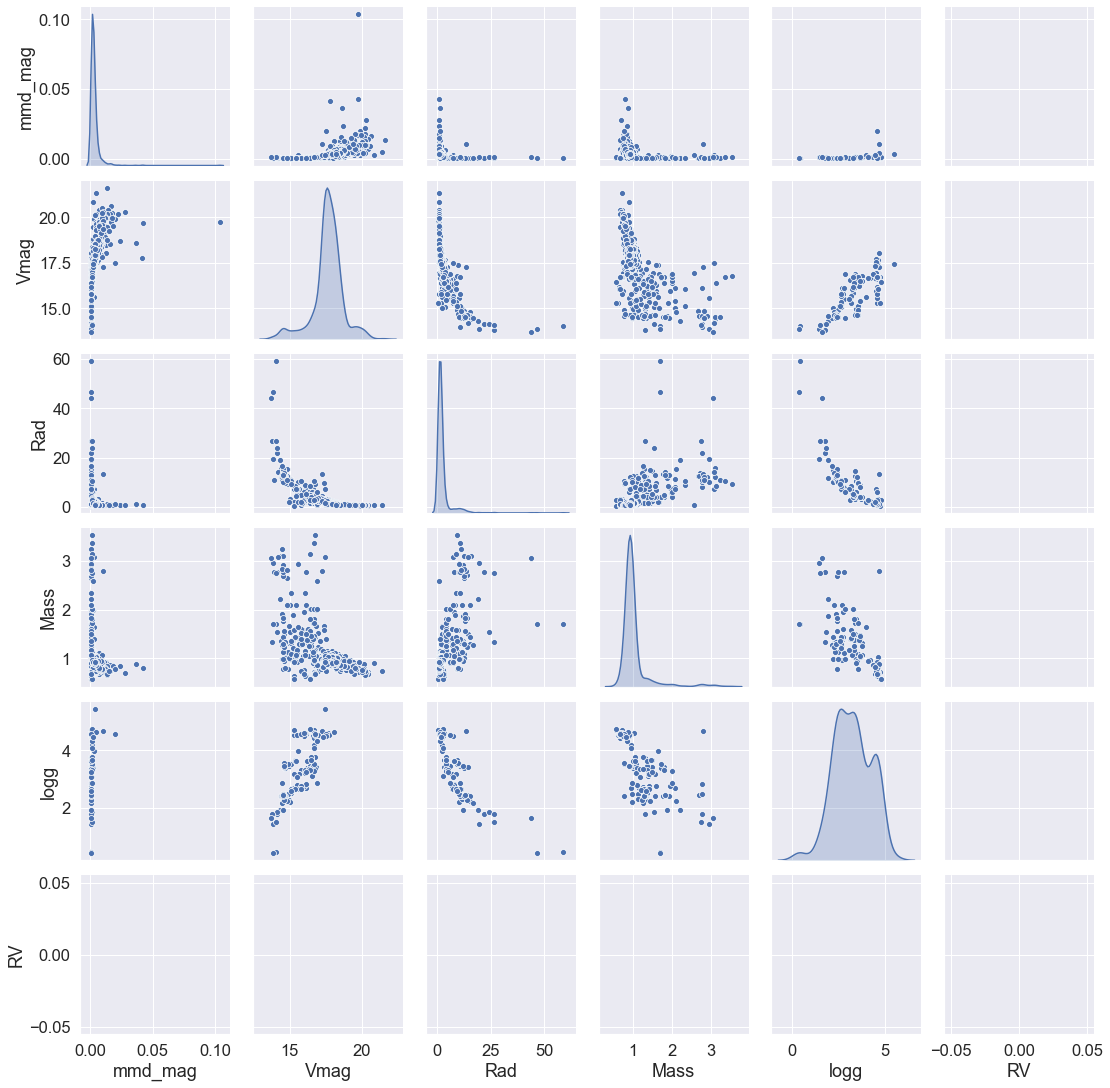

In [339]:
plt.figure(figsize=(10,10))
sns.set(style="ticks", color_codes=True)
sns.set(font_scale=1.5) 
#drop columns without numeric values and others unnecessary to explore in the pair plot
sns.pairplot(data=df[df.Vmag>0][["mmd_mag","Vmag","Rad","Mass","logg","RV"]], dropna=True,diag_kind = 'kde')

We definitely need more data to say anything about RV, logg, etc. 

Lastly, I'm plotting a V-K vs. Vmag plot with sizes illustrating the relative radius of the stars and colors indicating the log of the mmd. 

(-1.0, 2.6)

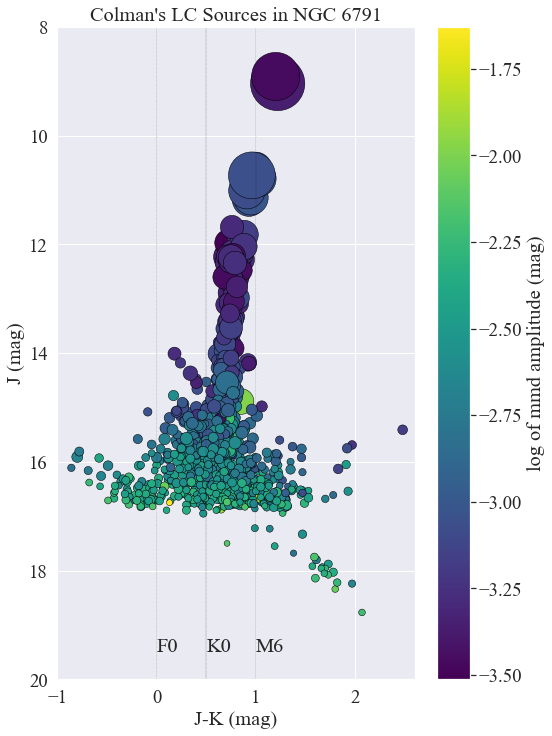

In [408]:
plt.figure(figsize=(8,12))
sns.set(font_scale=1.7) 
sns.set_style({'font.family': 'Times New Roman'})
plt.scatter(df.JminK[df.Jmag>0],df.Jmag[df.Jmag>0],c=np.log10(df.mmd_mag[df.Jmag>0]),\
            cmap='viridis',s=df.Rad[df.Jmag>0]*50,edgecolors='black',linewidth=0.5)

ymin=8
ymax=20

plt.annotate("F0",xy=(0,19.5))
plt.annotate("K0",xy=(0.5,19.5))
plt.annotate("M6",xy=(1.0,19.5))
plt.vlines(0,ymin,ymax,linewidth=0.25,linestyle='dashed')
plt.vlines(0.5,ymin,ymax,linewidth=0.25,linestyle='dashed')
plt.vlines(1.0,ymin,ymax,linewidth=0.25,linestyle='dashed')
plt.xlabel('J-K (mag)')
plt.ylabel('J (mag)')
plt.colorbar(label='log of mmd amplitude (mag)')
plt.title("Colman's LC Sources in NGC 6791")

plt.ylim(ymax,ymin)
plt.xlim(-1,2.6)

Text(0, 0.5, 'Radius ($\\mathrm{R_{\\odot}}$)')

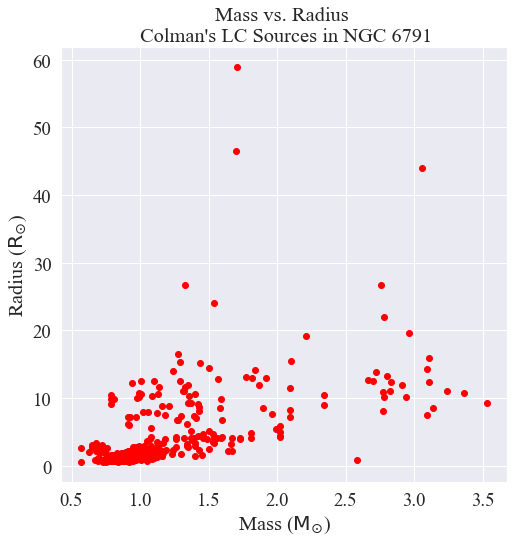

In [420]:
plt.figure(figsize=(8,8))
sns.set(font_scale=1.7) 
sns.set_style({'font.family': 'Times New Roman'})

plt.scatter(df.Mass,df.Rad,c='red')
plt.title("Mass vs. Radius \n Colman's LC Sources in NGC 6791")
plt.xlabel('Mass ($\mathrm{M_{\odot}}$)')
plt.ylabel('Radius ($\mathrm{R_{\odot}}$)')

plt.hist(df.Mass,bins=50)
plt.title("Mass Distribution \n Colman's LC Sources in NGC 6791")

(-1.0, 2.6)

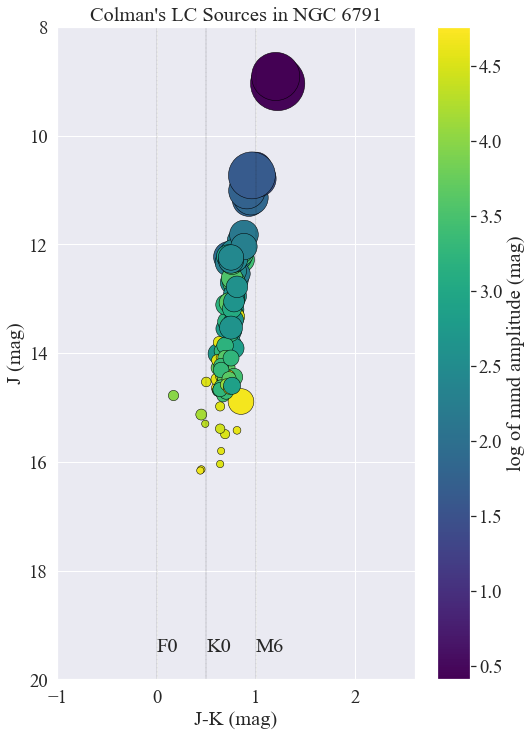

In [448]:
plt.figure(figsize=(8,12))
sns.set(font_scale=1.7) 
sns.set_style({'font.family': 'Times New Roman'})
plt.scatter(df.JminK[df.Jmag>0],df.Jmag[df.Jmag>0],c=(df.logg[df.Jmag>0]),\
            cmap='viridis',s=df.Rad[df.Jmag>0]*50,edgecolors='black',linewidth=0.5)

ymin=8
ymax=20

plt.annotate("F0",xy=(0,19.5))
plt.annotate("K0",xy=(0.5,19.5))
plt.annotate("M6",xy=(1.0,19.5))
plt.vlines(0,ymin,ymax,linewidth=0.25,linestyle='dashed')
plt.vlines(0.5,ymin,ymax,linewidth=0.25,linestyle='dashed')
plt.vlines(1.0,ymin,ymax,linewidth=0.25,linestyle='dashed')
plt.xlabel('J-K (mag)')
plt.ylabel('J (mag)')
plt.colorbar(label='log of mmd amplitude (mag)')
plt.title("Colman's LC Sources in NGC 6791")

plt.ylim(ymax,ymin)
plt.xlim(-1,2.6)

In [454]:
df.columns

Index(['RA', 'DEC', 'KEPID', 'mmd_flux', 'mmd_mag', 'GaiaID', 'KIC', 'TIC',
       'Vmag', 'Jmag', 'Kmag', 'kepmag', 'Imag', 'Rmag', 'Bmag', 'pmRA',
       'pmDE', 'e_pmRA', 'e_pmDE', 'Rad', 'Mass', 'Lum', 'logg', 'LClass',
       'RV', 'Teff', 'Dist', 'e_Dist', 'ProbCluster', 'VminK', 'JminK'],
      dtype='object')